# Análisis y Exploración de Datos - Tienda Online

Este notebook presenta un análisis exploratorio de ventas de una tienda online utilizando el dataset **Online Retail II**.  
El objetivo es comprender el comportamiento de los clientes y los patrones de compra, identificar productos destacados y detectar oportunidades para optimizar las decisiones del negocio.

A lo largo del análisis se aplicarán técnicas de preprocesamiento de datos, detección de valores nulos o inconsistentes, generación de variables relevantes como *TotalPrice* o *YearMonth*, y agrupaciones por cliente y país para obtener insights estratégicos.


# PROCESAMIENTO DE DATOS
## 1. Carga inicial y revisión estructural del conjunto de datos

A continuación se importan las librerías necesarias para el análisis y se establece el estilo de los gráficos.
Además, se realiza una primera inspección estructural del dataset para conocer su tamaño, columnas, tipos de datos y valores únicos por campo. Esto permite anticipar posibles ajustes de formato y comprender la naturaleza de los datos antes del preprocesamiento.

In [26]:
# Importacion de librerias

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración de estilo gráfico
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 13

In [27]:
# Definimos la ruta del archivo Excel (***AJUSTAR***)
file_path = "C:/Users/LORENA SIERRA/Downloads/online_retail_II (3).xlsx"

# Cargamos el archivo como objeto Excel para acceder a sus hojas
xls = pd.ExcelFile(file_path)

# Leemos las dos hojas del archivo que contienen los registros de ventas por año
df1 = xls.parse('Year 2009-2010')
df2 = xls.parse('Year 2010-2011')

# Agregar columna identificadora del origen
df1['Year'] = '2009-2010'
df2['Year'] = '2010-2011'

# Unir en un único DataFrame
df = pd.concat([df1, df2], ignore_index=True)


In [29]:
# 1. Mostrar tamaño del dataset
print(f"📦 Tamaño del dataset: {df.shape[0]} filas y {df.shape[1]} columnas")

# 2. Mostrar columnas disponibles
print("\n🧾 Columnas disponibles:")
display(pd.DataFrame(df.columns, columns=["Columnas"]))

# 3. Tipos de datos por columna
print("\n🔢 Tipos de datos por columna:")
display(pd.DataFrame(df.dtypes, columns=["Tipo de dato"]))

# 4. Cantidad de valores únicos por columna
print("\n🔍 Cantidad de valores únicos por columna:")
display(df.nunique().sort_values(ascending=False).to_frame("Valores únicos"))

# 5. Vista previa con estilo (las 10 primeras filas)
print("\n👁 Vista previa de los primeros 10 registros:")
df.head(10).style.set_properties(**{
    'text-align': 'left',
    'background-color': '#f9f9f9',
    'color': 'black',  # <--- Aquí forzamos letra negra
    'border': '1px solid lightgray',
    'font-size': '12px'
})

📦 Tamaño del dataset: 1067371 filas y 9 columnas

🧾 Columnas disponibles:


,Columnas
0,Invoice
1,StockCode
2,Description
3,Quantity
4,InvoiceDate
5,Price
6,Customer ID
7,Country
8,Year



🔢 Tipos de datos por columna:


,Tipo de dato
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object
Year,object



🔍 Cantidad de valores únicos por columna:


,Valores únicos
Invoice,53628
InvoiceDate,47635
Customer ID,5942
Description,5698
StockCode,5305
Price,2807
Quantity,1057
Country,43
Year,2



👁 Vista previa de los primeros 10 registros:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom,2009-2010
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom,2009-2010
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom,2009-2010
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.100000,13085.000000,United Kingdom,2009-2010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.250000,13085.000000,United Kingdom,2009-2010
5,489434,22064,PINK DOUGHNUT TRINKET POT,24,2009-12-01 07:45:00,1.650000,13085.000000,United Kingdom,2009-2010
6,489434,21871,SAVE THE PLANET MUG,24,2009-12-01 07:45:00,1.250000,13085.000000,United Kingdom,2009-2010
7,489434,21523,FANCY FONT HOME SWEET HOME DOORMAT,10,2009-12-01 07:45:00,5.950000,13085.000000,United Kingdom,2009-2010
8,489435,22350,CAT BOWL,12,2009-12-01 07:46:00,2.550000,13085.000000,United Kingdom,2009-2010
9,489435,22349,"DOG BOWL , CHASING BALL DESIGN",12,2009-12-01 07:46:00,3.750000,13085.000000,United Kingdom,2009-2010


## 2. Revisión general y tratamiento de valores nulos

En esta etapa se realiza un análisis exploratorio para detectar la presencia de valores faltantes en las distintas columnas del conjunto de datos.

Se calcula la cantidad total de valores nulos y el porcentaje que representan respecto al total de registros.  
Este paso es clave para tomar decisiones fundamentadas sobre qué columnas requieren limpieza o tratamiento especial en el preprocesamiento posterior.

In [30]:
# Conteo de valores nulos por columna
null_counts = df.isnull().sum()

# Porcentaje de valores nulos respecto al total de registros
null_percent = (null_counts / len(df)) * 100

# Crear resumen organizado en un DataFrame
null_summary = pd.DataFrame({
    'Columna': null_counts.index,
    'Valores nulos': null_counts.values,
    'Porcentaje (%)': null_percent.values
}).sort_values(by='Valores nulos', ascending=False).reset_index(drop=True)

# Visualización con estilo claro y uniforme
print("🧼 Conteo de valores nulos por columna:")
display(null_summary.style.format({'Porcentaje (%)': '{:.2f}'})
        .set_properties(**{
            'text-align': 'center',
            'background-color': '#f9f9f9',
            'color': 'black',
            'border': '1px solid lightgray',
            'font-size': '12px'
        }))

🧼 Conteo de valores nulos por columna:


,Columna,Valores nulos,Porcentaje (%)
0,Customer ID,243007,22.77
1,Description,4382,0.41
2,Invoice,0,0.00
3,Quantity,0,0.00
4,StockCode,0,0.00
5,InvoiceDate,0,0.00
6,Price,0,0.00
7,Country,0,0.00
8,Year,0,0.00


### 2.1 Análisis de la columna `Customer ID` y justificación de su tratamiento

A partir del análisis de valores nulos realizado en el bloque anterior, se detectó que la columna `Customer ID` presenta un porcentaje significativo de datos faltantes: **22,77%** del total de registros.

Esto plantea la necesidad de decidir si estos registros deben ser eliminados o conservados como parte del análisis general.

#### Análisis conceptual y justificación

Los registros con `Customer ID` nulo representan ventas en las que no se identificó al cliente.  
Esto puede deberse a errores en el registro o a compras realizadas sin asociar un perfil de cliente.

Para el análisis exploratorio de ventas en general (por productos, por país, por fechas, etc.), estos datos siguen siendo válidos y pueden aportar información importante sobre comportamiento de consumo.

Sin embargo, para análisis centrados en el cliente (como gasto promedio por usuario, frecuencia de compra, fidelización, etc.), dichos registros no serán útiles.

---

🔎 **Decisión adoptada:**

✅ Se conservarán los registros con `Customer ID` nulo.  
Cuando se requiera un análisis específico por cliente, se filtrarán en ese momento.

In [31]:
# Contar registros con y sin 'Customer ID'
con_id = df[df['Customer ID'].notnull()].shape[0]
sin_id = df[df['Customer ID'].isnull()].shape[0]
total = len(df)

# Preparar DataFrame resumen
resumen_id = pd.DataFrame({
    "Categoría": ["Con Customer ID", "Sin Customer ID", "Total"],
    "Cantidad": [con_id, sin_id, total],
    "Porcentaje": [
        f"{round(con_id/total*100, 2)}%",
        f"{round(sin_id/total*100, 2)}%",
        "100%"
    ]
})

# Mostrar como tabla
print("📊 Distribución de registros según disponibilidad de Customer ID:")
resumen_id.style.set_properties(**{
    'text-align': 'center',
    'background-color': '#f9f9f9',
    'color': 'black',
    'border': '1px solid lightgray',
    'font-size': '12px'
})


# Nota: No se eliminan los registros sin 'Customer ID' ya que representan ventas reales,
# aunque no asociadas a un cliente identificado.

📊 Distribución de registros según disponibilidad de Customer ID:


,Categoría,Cantidad,Porcentaje
0,Con Customer ID,824364,77.23%
1,Sin Customer ID,243007,22.77%
2,Total,1067371,100%


### 2.2 Análisis de la columna `Description` y justificación de su tratamiento

La columna `Description` contiene el nombre o la descripción del producto vendido en cada transacción.  
Esta información es clave para análisis relacionados con productos, como identificar los más vendidos, categorizar artículos, o detectar patrones de compra.

Durante la revisión general de valores nulos, se identificaron registros en los que este campo está vacío.  
A continuación, se analiza cuántos son, qué porcentaje representan del total y se define la acción correspondiente.

#### Análisis conceptual y justificación

Los registros sin descripción no permiten saber qué producto fue vendido, lo que impide incluirlos en cualquier análisis relacionado con artículos o categorías.

Además, representan una **proporción muy baja** del total (menos del 0.5%), por lo que su eliminación no afecta significativamente el tamaño ni la calidad del dataset.

---

🔎 **Decisión adoptada:**

❌ Se eliminarán los registros que tengan `Description` nula para asegurar que el análisis de productos sea consistente y confiable.

In [32]:
# Contar registros con valores nulos en 'Description'
desc_null_count = df['Description'].isnull().sum()
total_rows = len(df)
desc_null_pct = round((desc_null_count / total_rows) * 100, 2)

print(f"Registros con 'Description' nula: {desc_null_count} ({desc_null_pct}%)")

# Justificación:
# Representan un porcentaje muy bajo y no aportan valor para el análisis de productos,
# ya que no se puede saber qué fue lo que se vendió.

# Eliminar registros con 'Description' nula
df = df.dropna(subset=['Description'])

# Comentario final del tratamiento (puede variar según ejecución previa)
print(f"Se eliminaron {desc_null_count} registros con 'Description' nula ({desc_null_pct}%).")

Registros con 'Description' nula: 4382 (0.41%)
Se eliminaron 4382 registros con 'Description' nula (0.41%).


### 2.3 Diagnóstico general de valores nulos

Antes de continuar con el preprocesamiento, se genera una visualización general de los valores faltantes en todas las columnas para facilitar el diagnóstico global.

In [33]:
# Conteo y porcentaje de valores nulos por columna
null_counts = df.isnull().sum()
null_percent = (null_counts / len(df)) * 100

# Crear resumen ordenado
null_summary = pd.DataFrame({
    'Columna': null_counts.index,
    'Valores nulos': null_counts.values,
    'Porcentaje (%)': null_percent.values
}).sort_values(by='Valores nulos', ascending=False).reset_index(drop=True)

# Mostrar tabla con estilo
print("🧼 Resumen de valores nulos por columna:")
display(null_summary.style.format({'Porcentaje (%)': '{:.2f}'})
        .set_properties(**{
            'text-align': 'center',
            'background-color': '#f9f9f9',
            'color': 'black',
            'border': '1px solid lightgray',
            'font-size': '12px'
        }))

🧼 Resumen de valores nulos por columna:


,Columna,Valores nulos,Porcentaje (%)
0,Customer ID,238625,22.45
1,Invoice,0,0.00
2,StockCode,0,0.00
3,Quantity,0,0.00
4,Description,0,0.00
5,InvoiceDate,0,0.00
6,Price,0,0.00
7,Country,0,0.00
8,Year,0,0.00


### 2.4  Cierre del bloque 
Con este bloque se han identificado y tratado los principales valores faltantes del dataset:

- Se conservaron registros con `Customer ID` nulo por su valor informativo.
- Se eliminaron los registros sin `Description` por no aportar valor al análisis.
- Se visualizó el panorama general de valores nulos restantes.

Esto deja el conjunto de datos en condiciones más limpias y confiables para continuar con el análisis.

## 3. Normalización y limpieza fina de columnas clave

En esta etapa se realiza una normalización de algunas columnas clave del conjunto de datos para mejorar la integridad y facilitar los análisis posteriores.

Se corrigen inconsistencias en los tipos de datos, se eliminan decimales innecesarios en campos numéricos y se convierten identificadores a un formato más apropiado.
Estas transformaciones garantizan una estructura más limpia, comprensible y coherente, manteniendo siempre los valores nulos cuando es necesario.

In [34]:
# Convertir 'Invoice' a entero si todos los valores son numéricos
if df['Invoice'].str.isnumeric().all():
    df['Invoice'] = df['Invoice'].astype('int64')

# Redondear precios a dos decimales para facilitar su lectura y análisis
df['Price'] = df['Price'].round(2)

# Convertir Customer ID a entero sin perder valores nulos
df['Customer ID'] = df['Customer ID'].astype('Int64')

## 4. Tratamiento de valores inconsistentes (Quantity y Price)

 ### 4.1 Detección de valores inconsistentes

En esta sección se analizarán registros con valores **negativos** en las columnas `Quantity` y `Price`.

Estas variables representan la cantidad de productos vendidos y su precio por unidad.  
Por tanto, los valores negativos pueden ser indicadores de **inconsistencias** o tener un significado especial (por ejemplo, devoluciones).

Antes de tomar decisiones, se identificará cuántos registros presentan estos valores para evaluar su impacto y proceder a su análisis.

In [35]:
# Contar registros con valores negativos en Quantity y Price
neg_qty = df[df['Quantity'] < 0]
neg_price = df[df['Price'] < 0]

# Crear resumen en tabla
resumen_negativos = pd.DataFrame({
    "Columna": ["Quantity", "Price"],
    "Cantidad de valores negativos": [neg_qty.shape[0], neg_price.shape[0]]
})

# Mostrar resumen con estilo
print("⚠️ Registros con valores negativos:")
display(resumen_negativos.style.set_properties(**{
    'text-align': 'center',
    'background-color': '#fef6f6',
    'color': 'black',
    'border': '1px solid lightgray',
    'font-size': '12px'
}))

# Mostrar ejemplos
print("\n🔍 Ejemplos de registros con Quantity negativa:")
display(neg_qty.head().style.set_properties(**{
    'text-align': 'left',
    'background-color': '#fffdf6',
    'color': 'black',
    'border': '1px solid lightgray',
    'font-size': '12px'
}))

print("\n🔍 Ejemplos de registros con Price negativa:")
display(neg_price.head().style.set_properties(**{
    'text-align': 'left',
    'background-color': '#fffdf6',
    'color': 'black',
    'border': '1px solid lightgray',
    'font-size': '12px'
}))

⚠️ Registros con valores negativos:


,Columna,Cantidad de valores negativos
0,Quantity,20261
1,Price,5



🔍 Ejemplos de registros con Quantity negativa:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.950000,16321,Australia,2009-2010
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.650000,16321,Australia,2009-2010
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.250000,16321,Australia,2009-2010
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.100000,16321,Australia,2009-2010
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.950000,16321,Australia,2009-2010



🔍 Ejemplos de registros con Price negativa:


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.360000,,United Kingdom,2009-2010
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.790000,,United Kingdom,2009-2010
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.870000,,United Kingdom,2009-2010
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.060000,,United Kingdom,2010-2011
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.060000,,United Kingdom,2010-2011


### 4.2 Análisis conceptual de los valores negativos

***Análisis de Quantity negativa:
Se encontraron 20.261 registros con Quantity negativa.

Al revisar ejemplos, se observa que muchos corresponden a productos específicos (como canastas o decoraciones) con cantidades como -6, -4 o -12.

Esto sugiere que no se trata de errores, sino de devoluciones o cancelaciones de pedidos, lo cual es común en datos de ventas reales.

- Conclusión: No son errores, sino eventos válidos del negocio. Su presencia puede enriquecer el análisis si se desea evaluar comportamiento postventa, devoluciones por país o cliente, etc.

***Análisis de Price negativa:
Solo hay 5 registros con Price negativo.

La descripción es "Adjust bad debt", todos con cantidades de 1 unidad y precios extremadamente negativos (como -53594.36).

No tienen Customer ID, y el país es United Kingdom.

Representan ajustes contables o cancelaciones por deuda incobrable.

- Conclusión: Estos valores no aportan al análisis comercial o de comportamiento de compra. De hecho, pueden distorsionar los cálculos de ingresos o promedios de venta si se mantienen.

### 4.3 Tratamiento de valores negativos en Quantity y Price

Con base en el análisis anterior, se decide:

- ✅ **Conservar los registros con `Quantity` negativa**:
    Representan devoluciones o cancelaciones reales que pueden ser útiles para estudios de postventa o comportamiento de clientes.

- ❌ **Eliminar los registros con `Price` negativa**:
    Corresponden a ajustes contables no asociados a clientes, sin valor para el análisis comercial, y que podrían distorsionar métricas como ingresos, precios promedio o ventas totales.

In [38]:
# Filtrar registros con Price negativa
neg_price = df[df['Price'] < 0]
price_neg_count = neg_price.shape[0]
total_rows_before = df.shape[0]

# Eliminar los registros
df = df[df['Price'] >= 0]
total_rows_after = df.shape[0]
rows_removed = total_rows_before - total_rows_after

# Crear tabla resumen
eliminacion_resumen = pd.DataFrame({
    "Descripción": [
        "Registros con Price negativa eliminados",
        "Total de registros antes de eliminar",
        "Total de registros después de eliminar"
    ],
    "Cantidad": [rows_removed, total_rows_before, total_rows_after]
})

# Mostrar con estilo
print(" Resumen de limpieza: Eliminación de precios negativos")
display(eliminacion_resumen.style.set_properties(**{
    'text-align': 'center',
    'background-color': '#fefcf3',
    'color': 'black',
    'border': '1px solid lightgray',
    'font-size': '12px'
}))

 Resumen de limpieza: Eliminación de precios negativos


,Descripción,Cantidad
0,Registros con Price negativa eliminados,0
1,Total de registros antes de eliminar,1062984
2,Total de registros después de eliminar,1062984


## 5. Transformación de columnas: InvoiceDate

Confirmamos que la columna InvoiceDate ya se encuentra en formato datetime64, lo cual permite la extracción directa de componentes temporales como año, mes o día.”

In [41]:
# A partir de la columna 'InvoiceDate' (en formato datetime), se crean nuevas variables temporales 
# para facilitar análisis por año, mes, día de la semana y hora.

# Año de la factura
df['InvoiceYear'] = df['InvoiceDate'].dt.year

# Mes de la factura
df['InvoiceMonth'] = df['InvoiceDate'].dt.month

# Día de la semana (nombre, ej: Monday)
df['InvoiceWeekday'] = df['InvoiceDate'].dt.day_name()

# Hora (por si se requiere análisis temporal más detallado)
df['InvoiceHour'] = df['InvoiceDate'].dt.hour

# Fecha sin hora (ya la habíamos creado antes, pero se incluye aquí por coherencia)
df['DateOnly'] = df['InvoiceDate'].dt.date

# Visualizamos las primeras filas para verificar la creación de las nuevas columnas
print("Verificación de nuevas columnas temporales derivadas de 'InvoiceDate'")
display(
    df[['InvoiceDate', 'InvoiceYear', 'InvoiceMonth', 'InvoiceWeekday', 'InvoiceHour', 'DateOnly']]
    .head(10)
    .style.set_properties(**{
        'text-align': 'center',
        'background-color': '#f9f9f9',
        'color': 'black',
        'border': '1px solid lightgray',
        'font-size': '12px'
    })
)

Verificación de nuevas columnas temporales derivadas de 'InvoiceDate'


,InvoiceDate,InvoiceYear,InvoiceMonth,InvoiceWeekday,InvoiceHour,DateOnly
0,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
1,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
2,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
3,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
4,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
5,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
6,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
7,2009-12-01 07:45:00,2009,12,Tuesday,7,2009-12-01
8,2009-12-01 07:46:00,2009,12,Tuesday,7,2009-12-01
9,2009-12-01 07:46:00,2009,12,Tuesday,7,2009-12-01


Justificación final:

La creación de estas variables permite realizar análisis temporales más específicos, como:

Comportamiento de compras por año o mes.

Identificación de patrones según el día de la semana o la hora del día.

Agrupaciones por fecha específica sin tener en cuenta la hora exacta.

🔹 Se decide conservar la columna InvoiceDate porque contiene la información completa y original en formato datetime, lo cual puede resultar útil para análisis avanzados (por ejemplo, intervalos entre compras, ordenamiento cronológico o reconstrucción de eventos).
De esta forma, se mantienen tanto la granularidad original como las nuevas variables derivadas para facilitar múltiples enfoques de análisis.

🔹De la misma forma, se decidió conservar la columna InvoiceDate en su formato original datetime, ya que este tipo de dato permite realizar análisis temporales más precisos y flexibles. Esto incluye la posibilidad de extraer componentes como año, mes, hora, o día de la semana, lo cual es fundamental para los objetivos analíticos del trabajo. Convertir esta columna a texto (string) limitaría estas capacidades.

## 6. Creación de nueva columna útil para el análisis: TotalPrice

En esta etapa se incorpora una nueva columna al conjunto de datos, con el objetivo de facilitar análisis futuros relacionados con el comportamiento de ventas.
La columna TotalPrice representa el valor monetario total de cada línea de factura, resultado de multiplicar la cantidad de artículos por su precio unitario. Esta variable será clave para estudiar ingresos por cliente, país o producto.

In [42]:
# Crear la columna 'TotalPrice' si aún no existe
df['TotalPrice'] = df['Quantity'] * df['Price']

# Visualizar muestra
df[['Quantity', 'Price', 'TotalPrice']].head().style\
    .format({'Price': '{:,.2f}', 'TotalPrice': '{:,.2f}'})\
    .background_gradient(cmap='PuBu')

,Quantity,Price,TotalPrice
0,12,6.95,83.40
1,12,6.75,81.00
2,12,6.75,81.00
3,48,2.10,100.80
4,24,1.25,30.00


- Comentario explicativo:
Se incorporó la columna TotalPrice al dataset, calculando el valor total por cada transacción.
Esta transformación no altera los datos originales, pero sí amplía el potencial analítico del conjunto, permitiendo evaluaciones posteriores más completas, como los ingresos por cliente o país.
Su creación es una etapa fundamental en el preprocesamiento antes de pasar al análisis estadístico o la visualización de datos.

## 7. Agrupaciones para análisis exploratorio inicial

 ### 7.1 Agrupación por cliente para análisis del comportamiento de compra

 En esta etapa se realiza una agrupación por el identificador de cliente (Customer ID) con el objetivo de analizar sus patrones de compra y evaluar su valor individual para el negocio.

Se calculan indicadores clave como:

- Cantidad total de artículos adquiridos

- Número de facturas generadas

- Monto total gastado

- Ticket promedio, definido como el gasto medio por factura

Este análisis permite segmentar a los clientes según su volumen de compras y detectar perfiles de alto valor. Además, es útil para estrategias comerciales y de fidelización, ya que facilita la identificación de los clientes más rentables.

Para asegurar la validez del análisis, se excluyen los registros sin Customer ID, dado que no permiten asociar las compras a un cliente específico.

In [44]:
# Crear columna 'TotalPrice'
df['TotalPrice'] = df['Quantity'] * df['Price']

# Filtrado de registros con Customer ID no nulo
# Esta versión limpia se usará para análisis relacionados con clientes y países
# Eliminar registros sin 'Customer ID' para asegurar trazabilidad del análisis
df_clean = df[df['Customer ID'].notnull()]

# Agrupar por cliente y calcular métricas relevantes
grouped_customers = df_clean.groupby('Customer ID').agg({
    'Invoice': 'nunique',        # Número de facturas distintas
    'Quantity': 'sum',           # Total de artículos adquiridos
    'TotalPrice': 'sum'          # Monto total gastado
}).rename(columns={
    'Invoice': 'Num_Facturas',
    'Quantity': 'Total_Articulos',
    'TotalPrice': 'Total_Gastado'
})

# Calcular ticket promedio por cliente
grouped_customers['Ticket_Promedio'] = (grouped_customers['Total_Gastado'] / grouped_customers['Num_Facturas']).round(2)

# Redondear Total_Gastado también
grouped_customers['Total_Gastado'] = grouped_customers['Total_Gastado'].round(2)

# Ordenar por gasto total y tomar top 10
top_customers = grouped_customers.sort_values(by='Total_Gastado', ascending=False).head(10)

# Visualización con estilo azul unificado
top_customers.style.format({
    'Total_Gastado': '{:,.2f}',
    'Ticket_Promedio': '{:,.2f}'
}).background_gradient(cmap="PuBu")

,Num_Facturas,Total_Articulos,Total_Gastado,Ticket_Promedio
Customer ID,,,,
18102,153,187110,"598,215.22","3,909.90"
14646,164,365220,"523,342.07","3,191.11"
14156,202,163910,"296,564.69","1,468.14"
14911,510,143741,"270,248.53",529.90
17450,61,81644,"233,579.39","3,829.17"
13694,164,185442,"190,825.52","1,163.57"
17511,85,117913,"171,885.98","2,022.19"
12415,33,91315,"143,269.29","4,341.49"
16684,65,101095,"141,502.25","2,176.96"


### 7.2 Agrupación por país: Total gastado y número de clientes por país

Esta agrupación permite observar el comportamiento de compra por país, brindando información útil sobre dónde se concentran las ventas y cuántos clientes distintos hay en cada región. Se calcula el monto total gastado (TotalPrice) y el número de clientes únicos (Customer ID) por país. Esta segmentación geográfica es clave para detectar mercados fuertes o potenciales y orientar estrategias comerciales.

In [45]:
# Crear columna 'TotalPrice' si aún no existe
df['TotalPrice'] = df['Quantity'] * df['Price']

# Filtrar registros válidos (con Customer ID no nulo)
df_clean = df[df['Customer ID'].notnull()]

# Agrupación por país: top 10 países por gasto
grouped_country = df_clean.groupby('Country').agg({
    'Customer ID': 'nunique',      # Clientes únicos
    'TotalPrice': 'sum'            # Total gastado
}).rename(columns={
    'Customer ID': 'Clientes_Unicos',
    'TotalPrice': 'Total_Gastado'
}).sort_values(by='Total_Gastado', ascending=False).head(10)

# Redondear columna de gasto a 2 decimales
grouped_country['Total_Gastado'] = grouped_country['Total_Gastado'].round(2)

# Mostrar tabla con estilo azul unificado
grouped_country.style.format({
    'Total_Gastado': '{:,.2f}'
}).background_gradient(cmap='PuBu')

,Clientes_Unicos,Total_Gastado
Country,,
United Kingdom,5410,"13,806,423.01"
EIRE,5,"578,501.63"
Netherlands,23,"548,524.95"
Germany,107,"417,988.56"
France,95,"326,504.67"
Australia,15,"167,129.07"
Switzerland,22,"99,082.81"
Spain,41,"91,859.48"
Sweden,19,"87,455.42"


### 7.3 Agrupación por pais: Productos más populares por país

En esta sección identificamos el producto más comprado en cada país, según la cantidad total (Quantity). Este análisis es clave para entender qué artículos dominan las ventas en diferentes mercados y permitirá tomar decisiones de marketing y stock futuras.

In [46]:
# Agrupar por país y producto, sumando la cantidad vendida
productos_por_pais = df.groupby(['Country', 'Description'])['Quantity'].sum().reset_index()

# Ordenar por país y cantidad descendente
productos_por_pais = productos_por_pais.sort_values(['Country', 'Quantity'], ascending=[True, False])

# Seleccionar el producto más popular por país
top_productos_por_pais = productos_por_pais.groupby('Country').first().reset_index()

# Mostrar los primeros 10 países como ejemplo
top_productos_por_pais.head(10).style.set_caption("Productos más populares por país")\
    .format({'Quantity': '{:,.0f}'})\
    .background_gradient(cmap='PuBu')

,Country,Description,Quantity
0,Australia,MINI PAINT SET VINTAGE,"3,024"
1,Austria,SET 12 KIDS COLOUR CHALK STICKS,288
2,Bahrain,WHITE TALL PORCELAIN T-LIGHT HOLDER,102
3,Belgium,PACK OF 60 SPACEBOY CAKE CASES,624
4,Bermuda,BOYS ALPHABET IRON ON PATCHES,"1,152"
5,Brazil,DOLLY GIRL LUNCH BOX,25
6,Canada,RETRO COFFEE MUGS ASSORTED,504
7,Channel Islands,RAIN PONCHO,551
8,Cyprus,HEART DECORATION PAINTED ZINC,384
9,Czech Republic,WOODEN STAR CHRISTMAS SCANDINAVIAN,72


### 7.4 Agrupación por producto: Producto con mayores ingresos globales

En esta sección agruparemos los datos por el campo Description con el objetivo de identificar los productos más vendidos y los que generaron mayor ingreso total. Esta información es crucial para comprender cuáles son los artículos con mejor rendimiento en términos de volumen y rentabilidad.

In [47]:
# Crear la columna 'TotalPrice' si aún no existe
df['TotalPrice'] = df['Quantity'] * df['Price']

# Filtrar registros con 'Description' no nulo y 'Customer ID' válido
df_clean = df[(df['Description'].notnull()) & (df['Customer ID'].notnull())]

# Agrupar por producto (Description)
grouped_products = df_clean.groupby('Description').agg({
    'Quantity': 'sum',          # Total de unidades vendidas
    'TotalPrice': 'sum'         # Total ingresado por producto
}).rename(columns={
    'Quantity': 'Unidades_Vendidas',
    'TotalPrice': 'Ingresos_Totales'
}).sort_values(by='Ingresos_Totales', ascending=False)

# Redondear ingresos a 2 decimales
grouped_products['Ingresos_Totales'] = grouped_products['Ingresos_Totales'].round(2)

# Visualizar top 10 productos con mayor ingreso
top_products = grouped_products.head(10)

# Estilo visual unificado
top_products.style.format({
    'Ingresos_Totales': '{:,.2f}'
}).background_gradient(cmap='PuBu')

,Unidades_Vendidas,Ingresos_Totales
Description,,
REGENCY CAKESTAND 3 TIER,23446,"269,736.70"
WHITE HANGING HEART T-LIGHT HOLDER,90008,"242,700.51"
JUMBO BAG RED RETROSPOT,74564,"134,845.16"
ASSORTED COLOUR BIRD ORNAMENT,79434,"126,354.18"
POSTAGE,5078,"112,249.10"
PARTY BUNTING,23335,"102,686.23"
PAPER CHAIN KIT 50'S CHRISTMAS,29001,"78,366.93"
CHILLI LIGHTS,15591,"72,229.34"
BLACK RECORD COVER FRAME,19606,"67,127.15"


### 7.5 Agrupación por periodo: análisis de ingresos mensuales

Esta agrupación busca examinar la evolución de los ingresos a lo largo del tiempo.
El análisis mensual permite identificar patrones estacionales, meses de alto o bajo rendimiento en ventas, y posibles oportunidades o anomalías en la actividad comercial.

Para llevarlo a cabo, se genera una nueva columna YearMonth a partir del campo InvoiceDate, que permite agrupar todas las transacciones de cada mes. Luego se calcula el ingreso total mensual utilizando la columna TotalPrice.

Esta información resulta clave para la toma de decisiones estratégicas, ya que ofrece una visión clara del comportamiento financiero de la tienda a lo largo del año.

In [48]:
# Crear columna 'TotalPrice' si aún no existe
df['TotalPrice'] = df['Quantity'] * df['Price']

# Eliminar registros sin 'Customer ID' para asegurar trazabilidad del análisis
df_clean = df[df['Customer ID'].notnull()]

# Extraer año y mes en formato YYYY-MM
df_clean.loc[:, 'YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M').astype(str)

# Agrupar por mes y calcular ingresos totales
monthly_income = df_clean.groupby('YearMonth').agg({
    'TotalPrice': 'sum'
}).rename(columns={
    'TotalPrice': 'Ingresos_Mensuales'
})

# Redondear ingresos a dos decimales
monthly_income['Ingresos_Mensuales'] = monthly_income['Ingresos_Mensuales'].round(2)

# Visualización con estilo azul
monthly_income.style.format({
    'Ingresos_Mensuales': '{:,.2f}'
}).background_gradient(cmap="PuBu")

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\3886608484.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.loc[:, 'YearMonth'] = df_clean['InvoiceDate'].dt.to_period('M').astype(str)


,Ingresos_Mensuales
YearMonth,
2009-12,"663,272.05"
2010-01,"531,952.90"
2010-02,"489,399.58"
2010-03,"635,996.48"
2010-04,"560,635.02"
2010-05,"559,924.55"
2010-06,"571,459.91"
2010-07,"562,785.90"
2010-08,"587,256.46"


# ESTADISTICAS DESCRIPTIVAS

## 1. Resumen estadístico básico de variables numéricas

En este bloque se generará un resumen estadístico de las variables numéricas del conjunto de datos. Esto incluye medidas como la media, mediana, desviación estándar, valores mínimos y máximos. El objetivo es comprender la distribución de los datos y detectar posibles anomalías o tendencias.

In [50]:
# Seleccionar solo las columnas numéricas
numeric_cols = df_clean.select_dtypes(include='number')

# Generar resumen estadístico transpuesto (para ver variables como filas)
summary_stats = numeric_cols.describe().T

# Mostrar el resumen con formato elegante y visual
print("📊 Resumen estadístico de variables numéricas:")
display(
    summary_stats.style
        .format("{:,.2f}")
        .set_properties(**{
            'text-align': 'center',
            'background-color': '#f9f9f9',
            'color': 'black',
            'border': '1px solid lightgray',
            'font-size': '12px'
        })
        .background_gradient(cmap='PuBu')
)

📊 Resumen estadístico de variables numéricas:


,count,mean,std,min,25%,50%,75%,max
Quantity,"824,364.00",12.41,188.98,"-80,995.00",2.00,5.00,12.00,"80,995.00"
Price,"824,364.00",3.68,70.24,0.00,1.25,1.95,3.75,"38,970.00"
Customer ID,"824,364.00","15,324.64","1,697.46","12,346.00","13,975.00","15,255.00","16,797.00","18,287.00"
InvoiceYear,"824,364.00","2,010.42",0.57,"2,009.00","2,010.00","2,010.00","2,011.00","2,011.00"
InvoiceMonth,"824,364.00",7.50,3.45,1.00,5.00,8.00,11.00,12.00
InvoiceHour,"824,364.00",12.81,2.30,6.00,11.00,13.00,14.00,21.00
TotalPrice,"824,364.00",20.20,308.69,"-168,469.60",4.25,11.25,19.50,"168,469.60"


### Análisis del Resumen Estadístico
Tras generar el resumen estadístico para las variables numéricas, se observan varios puntos relevantes:

- Quantity (Cantidad):

El valor mínimo es -80,995, lo cual es inconsistente con una lógica de compra y sugiere devoluciones o errores de registro.

El valor máximo es también extremadamente alto (80,995), y la desviación estándar es grande (188.98), lo que confirma una alta dispersión y posibles outliers.

La mediana (50%) es de 5 unidades, lo cual es mucho menor al promedio (12.41), lo que sugiere una distribución sesgada a la derecha.

- Price (Precio):

El precio mínimo es 0, lo cual puede reflejar promociones o errores. El precio máximo es muy alto (38,970), lo que también podría ser un outlier.

El promedio es bajo (3.68) y la mayoría de los productos parecen tener un precio entre 1.25 y 3.75, según los percentiles.

- TotalPrice (Precio Total):

Presenta también un valor negativo extremo (-168,469.60) y un máximo positivo simétrico, lo que refleja probablemente devoluciones completas o errores en registros masivos.

Su media (20.20) es mucho mayor que la mediana (11.25), nuevamente sugiriendo valores extremos que distorsionan el promedio.

- Customer ID, InvoiceYear, InvoiceMonth, InvoiceHour:

Estas variables muestran distribuciones esperadas, sin valores extremos visibles (excepto si decidimos que 'Customer ID' debe tratarse como categórica).

Los años de factura van de 2009 a 2011, siendo 2010 el más frecuente (como indica la mediana).

La hora promedio de facturación es cercana a las 13 hs, con un rango que va de 6 a 21 hs, lo cual es coherente con el horario laboral.

## 2. Detección de valores extremos (outliers)

Para identificar posibles valores atípicos en el conjunto de datos, se aplicó el método del rango intercuartílico (IQR) sobre las columnas numéricas más relevantes: Quantity, Price y TotalPrice. Este enfoque permite detectar registros con valores inusualmente bajos o altos, que podrían influir negativamente en los análisis estadísticos posteriores. A partir de los resultados obtenidos, se analizará si estos outliers deben ser tratados, eliminados o conservados según su impacto en el contexto del negocio.

In [51]:
# Seleccionar columnas numéricas principales
cols_interes = ['Quantity', 'Price', 'TotalPrice']

# Crear diccionario para almacenar los resultados
outliers_info = {}

# Calcular outliers por IQR
for col in cols_interes:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
    
    outliers_info[col] = {
        'Total registros': len(df_clean),
        'Outliers detectados': len(outliers),
        'Porcentaje (%)': (len(outliers) / len(df_clean)) * 100
    }

# Convertir a DataFrame y redondear a 2 decimales
outliers_df = pd.DataFrame(outliers_info).T.round(2)

# Mostrar tabla con formato y estilo
outliers_df.style.format("{:,.2f}").background_gradient(cmap='PuBu')

,Total registros,Outliers detectados,Porcentaje (%)
Quantity,"824,364.00","54,067.00",6.56
Price,"824,364.00","71,125.00",8.63
TotalPrice,"824,364.00","69,132.00",8.39


### Análisis: Outliers
Se analizaron las variables Quantity, Price y TotalPrice utilizando el método del rango intercuartílico (IQR). Los resultados muestran que:

La variable Quantity presenta 54.067 valores atípicos, lo que representa un 6.56% del total de registros.

La variable Price presenta 71.125 outliers, es decir, un 8.63% del total.

La variable TotalPrice tiene 69.132 valores atípicos, correspondientes al 8.39% del conjunto de datos.

Estos valores extremos podrían deberse a errores de carga (por ejemplo, devoluciones mal registradas o productos con precios inusuales) o bien representar casos reales pero excepcionales (como compras mayoristas o productos premium).
- Decisión: Por el momento, se conservarán los datos para no alterar el comportamiento natural del dataset, pero se mantendrán en observación para posibles ajustes en futuras etapas del análisis.

## 3 Relación entre variables numéricas

En esta sección analizaremos la relación entre las variables numéricas del conjunto de datos, particularmente observando la correlación entre ellas. Esto permite identificar si existen asociaciones lineales fuertes, moderadas o débiles entre variables clave como Quantity, Price y TotalPrice, lo cual puede ser útil para comprender patrones de comportamiento de compra.

In [52]:
# Seleccionar columnas numéricas de interés
cols_interes = ['Quantity', 'Price', 'TotalPrice']

# Calcular matriz de correlación y redondear a 2 decimales
correlation_matrix = df_clean[cols_interes].corr().round(2)

# Mostrar con estilo y formato de 2 decimales
correlation_matrix.style.format("{:,.2f}").background_gradient(cmap='PuBu')

,Quantity,Price,TotalPrice
Quantity,1.00,-0.00,0.85
Price,-0.00,1.00,-0.15
TotalPrice,0.85,-0.15,1.00


#### Análisis / Insight: Relación entre Variables Numéricas (Quantity, Price, TotalPrice)

Se analizó la relación entre las variables numéricas más relevantes: `Quantity`, `Price` y `TotalPrice`, utilizando la **matriz de correlación de Pearson**. Las principales observaciones son:

- **Quantity y TotalPrice (0.85)**:  
  Muestran una **fuerte correlación positiva**, lo que confirma que a **mayor cantidad de artículos comprados, mayor es el gasto total**. Esto era esperable, ya que el total se calcula multiplicando la cantidad por el precio unitario.

- **Price y TotalPrice (-0.15)**:  
  Presentan una **correlación negativa débil**, lo que sugiere que los productos con **mayor precio tienden a comprarse en menor cantidad**, o que el **monto total no aumenta proporcionalmente con el precio**, sino con la cantidad.

- **Quantity y Price (≈ 0.00)**:  
  No tienen prácticamente ninguna correlación, indicando que los usuarios compran **productos caros o baratos en distintas cantidades sin un patrón definido**.

---

Estas correlaciones aportan información valiosa para comprender **cómo se comportan los clientes** y **cómo influyen las variables de cantidad y precio en el gasto total**, siendo útiles para ajustar estrategias de precios, promociones y stock.

# VISUALIZACION DE DATOS

 ## 1. ¿Cuáles son los productos más vendidos?

 ### Gráfico 1: Top 10 Productos más vendidos - (por cantidad de unidades vendidas)

Este gráfico mostrará los 10 productos más vendidos por cantidad total de unidades (Quantity), sin importar el precio.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\637359396.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_products.values, y=top_products.index, palette="Reds")


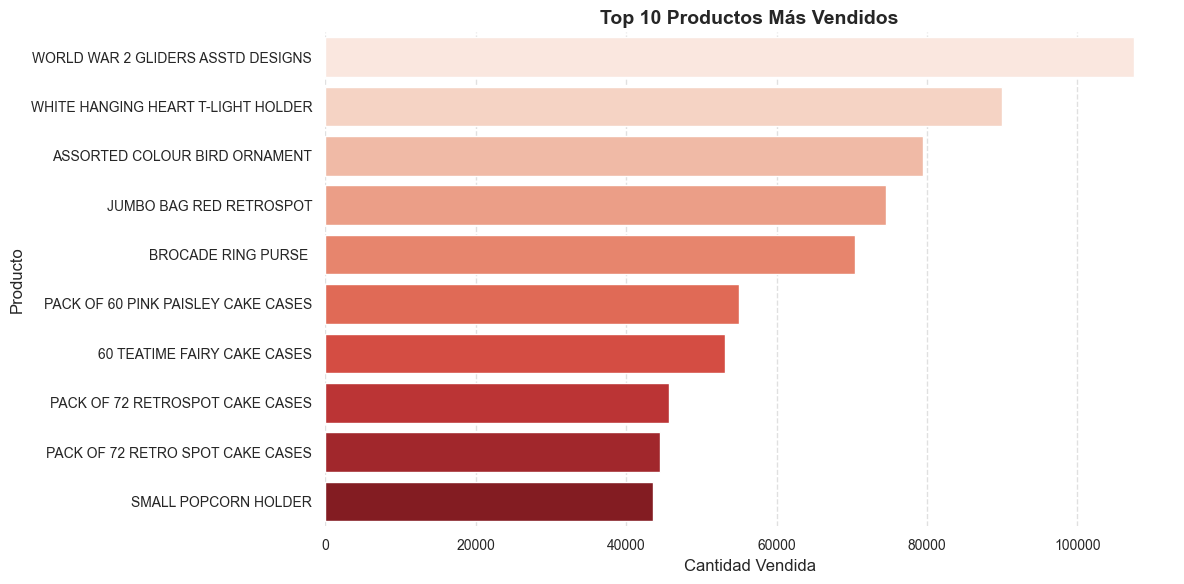

In [53]:
# Agrupar por descripción del producto y sumar la cantidad vendida
top_products = df_clean.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

# Estilo gráfico
plt.figure(figsize=(12,6))
sns.barplot(x=top_products.values, y=top_products.index, palette="Reds")

# Personalización completa
plt.title('Top 10 Productos Más Vendidos', fontsize=14, fontweight='bold')
plt.xlabel('Cantidad Vendida', fontsize=12)
plt.ylabel('Producto', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Top 10 Productos Más Vendidos

El gráfico muestra claramente los productos más populares en términos de cantidad de unidades vendidas. El artículo **"WORLD WAR 2 GLIDERS ASSTD DESIGNS"** lidera el ranking, seguido por **"WHITE HANGING HEART T-LIGHT HOLDER"** y **"ASSORTED COLOUR BIRD ORNAMENT"**, todos con volúmenes superiores a 75.000 unidades.

Esto sugiere que los **productos decorativos y de bajo costo** presentan una **alta rotación**, posiblemente porque son atractivos para **compras impulsivas** o para **revendedores**.

---

**Implicancias comerciales:**

- ✅ Estos productos pueden ser **estratégicos para promociones, bundles o campañas de marketing**.  
- ✅ Tener **niveles altos de stock** es clave para **no perder ventas potenciales**.  
- ✅ Sería interesante revisar si estos productos tienen un **margen de ganancia alto** o si su venta se **apoya en el volumen**.


 ### Gráfico 2: Top 10 Productos que generaron más ingresos
 
Este gráfico presenta los 10 productos que generaron mayores ingresos durante el período analizado, calculados como Cantidad * Precio. A diferencia del gráfico anterior, que priorizaba la cantidad vendida, aquí se destacan aquellos productos que, aunque puedan tener ventas moderadas, poseen un mayor valor unitario. Este enfoque permite identificar los artículos de mayor rentabilidad para la empresa.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\2994476468.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


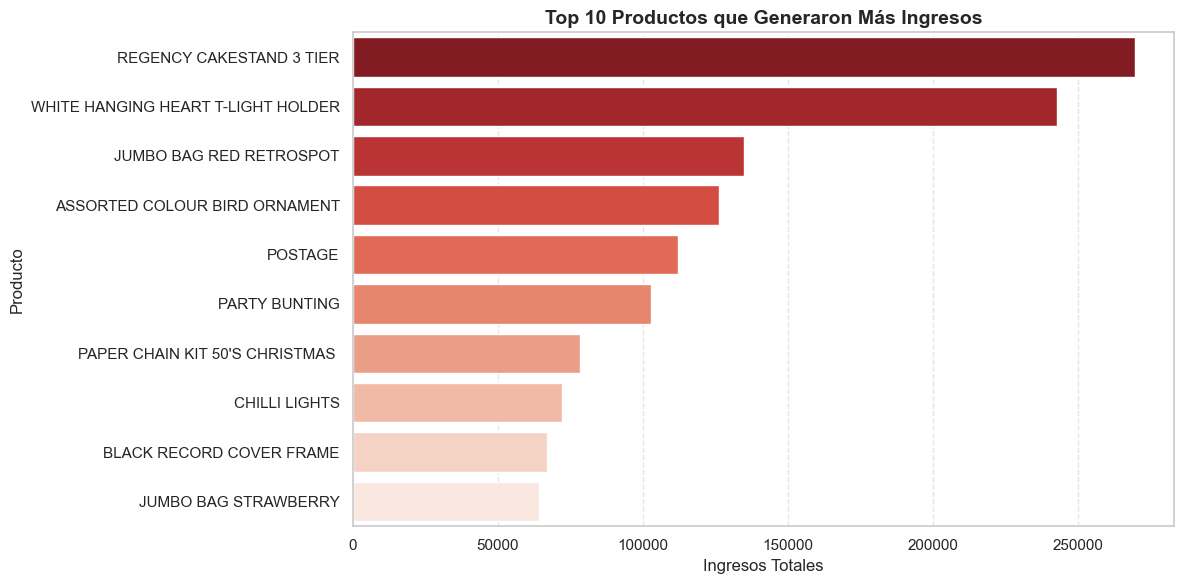

In [54]:
# Agrupar por producto (Description) y calcular ingresos totales
top_ingresos = (
    df_clean.groupby('Description')['TotalPrice']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

# Configuración del gráfico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_ingresos,
    x='TotalPrice',
    y='Description',
    palette='Reds_r'
)

# Personalización
plt.title('Top 10 Productos que Generaron Más Ingresos', fontsize=14, weight='bold')
plt.xlabel('Ingresos Totales', fontsize=12)
plt.ylabel('Producto', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Top 10 Productos que generaron más ingresos


El producto “REGENCY CAKESTAND 3 TIER” lidera el ranking con el mayor ingreso total, seguido muy de cerca por “WHITE HANGING HEART T-LIGHT HOLDER”.

Algunos productos que no estaban en el top por cantidad vendida aparecen aquí, lo que indica que su precio unitario es significativamente más alto.

Este gráfico es clave para identificar productos estratégicos en rentabilidad, aunque su volumen de venta no sea masivo.

 ## 2. ¿Qué días, semanas o meses tuvieron mayores ventas? ¿Hay patrones estacionales?

### Gráfico 1: Ingresos Totales por Mes

Este gráfico muestra la evolución de los ingresos mensuales (TotalPrice), permitiendo identificar estacionalidades o meses con mayores ventas.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\1051855691.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


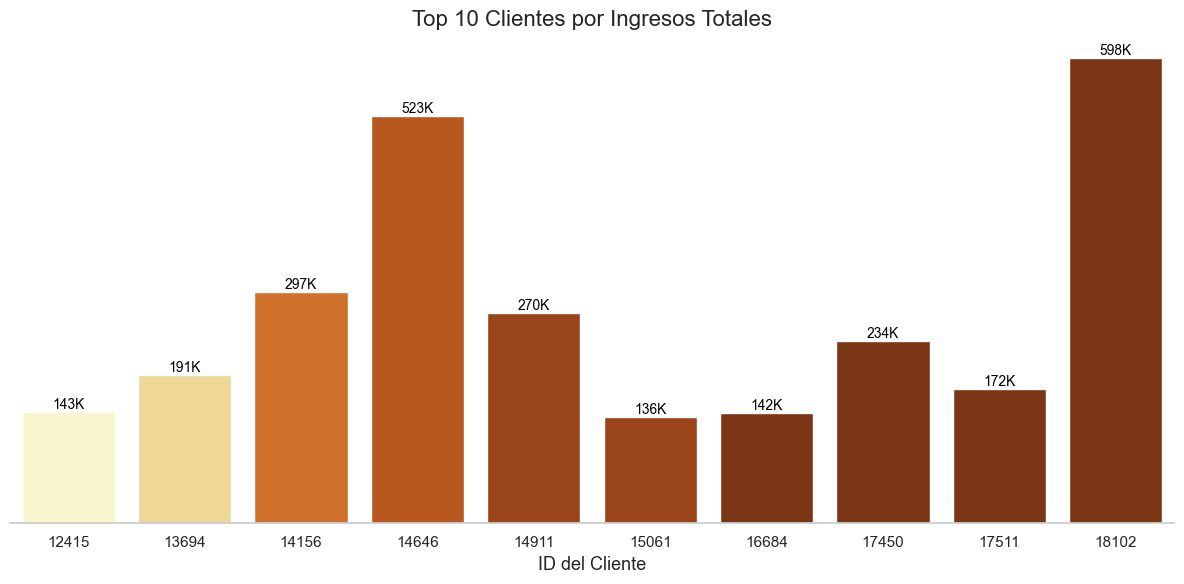

In [55]:
# Agrupar por cliente y obtener los 10 con mayor ingreso
top_clients = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

# Normalizar ingresos
from matplotlib.colors import Normalize
norm = Normalize(vmin=top_clients['TotalPrice'].min(), vmax=top_clients['TotalPrice'].max())

# Paleta invertida YlOrBr (más ingreso = más oscuro)
colors = sns.color_palette("YlOrBr", len(top_clients))[::-1]
mapped_colors = [colors[int(norm(val)*(len(colors)-1))] for val in top_clients['TotalPrice']]

# Crear gráfico
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x="Customer ID",
    y="TotalPrice",
    data=top_clients,
    palette=mapped_colors
)

# Título y etiquetas
plt.title("Top 10 Clientes por Ingresos Totales", fontsize=16)
plt.xlabel("ID del Cliente")
plt.ylabel("")

# Estilo: ocultar eje Y y bordes
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Etiquetas encima de cada barra (en miles con 'K')
for p in ax.patches:
    valor_k = p.get_height() / 1000
    ax.annotate(f'{valor_k:,.0f}K',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Análisis / Insight: Ingresos Totales por Mes

El gráfico muestra los ingresos totales por mes entre diciembre de 2009 y diciembre de 2011. A partir del análisis, se pueden extraer los siguientes puntos clave:

- **Picos de ingreso claramente identificables**:  
  Noviembre de 2010 y noviembre de 2011 presentan los ingresos más altos de todo el período, superando el millón y medio en ventas. Esto sugiere una **tendencia estacional** vinculada posiblemente al **Black Friday**, **promociones de fin de año**, o a una **planificación anticipada de compras navideñas**.  
  Octubre y diciembre también muestran ingresos significativamente altos, lo que refuerza la hipótesis de estacionalidad en el último trimestre del año.

- **Meses con menores ingresos**:  
  Febrero 2010, abril 2011 y diciembre 2011 presentan los ingresos más bajos. En el caso de febrero y abril, podría estar asociado a vacaciones o estacionalidad baja, mientras que diciembre 2011 sugiere un **cierre anticipado de operaciones** o una **caída puntual**.

- **Ciclo anual repetido**:  
  Se observa un patrón cíclico donde cada año el **último trimestre tiene un comportamiento mucho más alto que el resto**. Esto indica que la empresa puede **anticipar ventas fuertes hacia fin de año** y ajustar estrategias comerciales o logísticas en función de ello.

- **Estabilidad relativa en el resto del año**:  
  Exceptuando los picos y valles mencionados, la mayoría de los meses presentan un **rango de ingresos similar**, lo cual sugiere una **base sólida de ventas** que podría sostenerse a lo largo del tiempo.

---

**Recomendaciones:**

- ✅ Aprovechar los **meses pico** con campañas de marketing más agresivas y promociones específicas.  
- ✅ Analizar si los **meses con baja facturación** se relacionan con caídas de demanda, logística o disponibilidad de stock.  
- ✅ Preparar **inventario y personal operativo** para los meses de mayor demanda, especialmente **octubre y noviembre**.

### Gráfico 2: Ingresos totales por día de la semana

Este gráfico muestra el comportamiento de los ingresos según el día de la semana en que se realizó la compra. Permite detectar si hay días específicos con mayor actividad comercial, útil para estrategias de marketing o gestión operativa.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\156204718.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


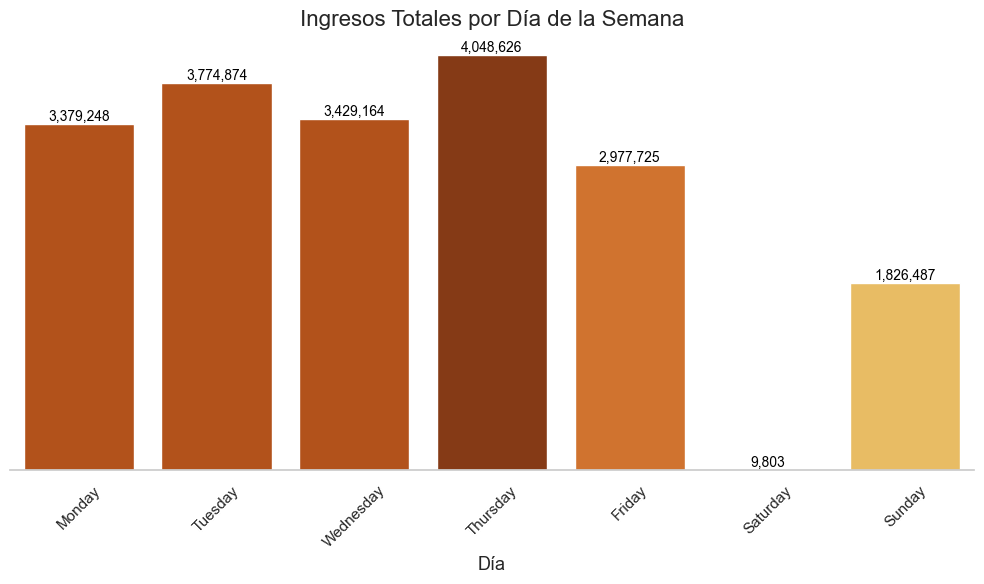

In [56]:
# Crear columna con el día de la semana
df['DayOfWeek'] = df['InvoiceDate'].dt.day_name()

# Ordenar los días en orden lógico (lunes a domingo)
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Agrupar por día de la semana y sumar los ingresos
df_dow = df.groupby('DayOfWeek')['TotalPrice'].sum().reindex(order_days).reset_index()

# Normalizar para el mapeo de color según monto
norm = Normalize(vmin=df_dow['TotalPrice'].min(), vmax=df_dow['TotalPrice'].max())
colors = sns.color_palette("YlOrBr", len(df_dow))
mapped_colors = [colors[int(norm(val)*(len(colors)-1))] for val in df_dow['TotalPrice']]

# Gráfico
plt.figure(figsize=(10,6))
ax = sns.barplot(
    x="DayOfWeek",
    y="TotalPrice",
    data=df_dow,
    palette=mapped_colors
)

# Títulos
plt.title("Ingresos Totales por Día de la Semana", fontsize=16)
plt.xlabel("Día")
plt.ylabel("")  # Eliminamos texto del eje Y
plt.xticks(rotation=45)

# Ocultar eje Y
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)  # Línea del eje Y
ax.spines['right'].set_visible(False)  # Línea derecha
ax.spines['top'].set_visible(False)  # Línea superior

# Agregar los valores encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Análisis / Insight: Ingresos Totales por Día de la Semana

Este gráfico revela cómo varían los ingresos según el día de la semana. Se observa que los días con mayor volumen de ventas son **jueves**, **martes** y **miércoles**, siendo el **jueves** el día más destacado en términos de ingresos.

Esto indica un patrón fuerte de actividad comercial en el **tramo medio de la semana laboral**, lo cual puede estar vinculado a la planificación de compras empresariales o comportamiento del consumidor online.

En contraste, los **fines de semana**, especialmente el **domingo**, registran un descenso significativo en ingresos. Además, **no se reportan ingresos los días sábado**, lo cual podría deberse a:

- Ausencia real de ventas ese día (cierre de operaciones).
- Acumulación de ventas en días adyacentes.
- Errores en el registro de fechas (zonas horarias, horarios de corte, etc.).

Este insight permite ajustar la estrategia comercial:
- **Optimizar campañas entre martes y jueves.**
- **Investigar la falta de ventas los sábados** para verificar si es una oportunidad desaprovechada o una restricción operativa.


## 3. ¿Cuál es el comportamiento de las compras por cliente?

### Gráfico 1: Distribución de compras – Top 10 clientes por ingresos totales

Este gráfico muestra los 10 clientes que más han gastado en total (`TotalPrice`). Es útil para detectar clientes estratégicos o VIP, analizar su comportamiento y establecer acciones de fidelización. También permite identificar si las ventas están concentradas en pocos compradores o si están más distribuidas en la base de clientes.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\1082035640.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


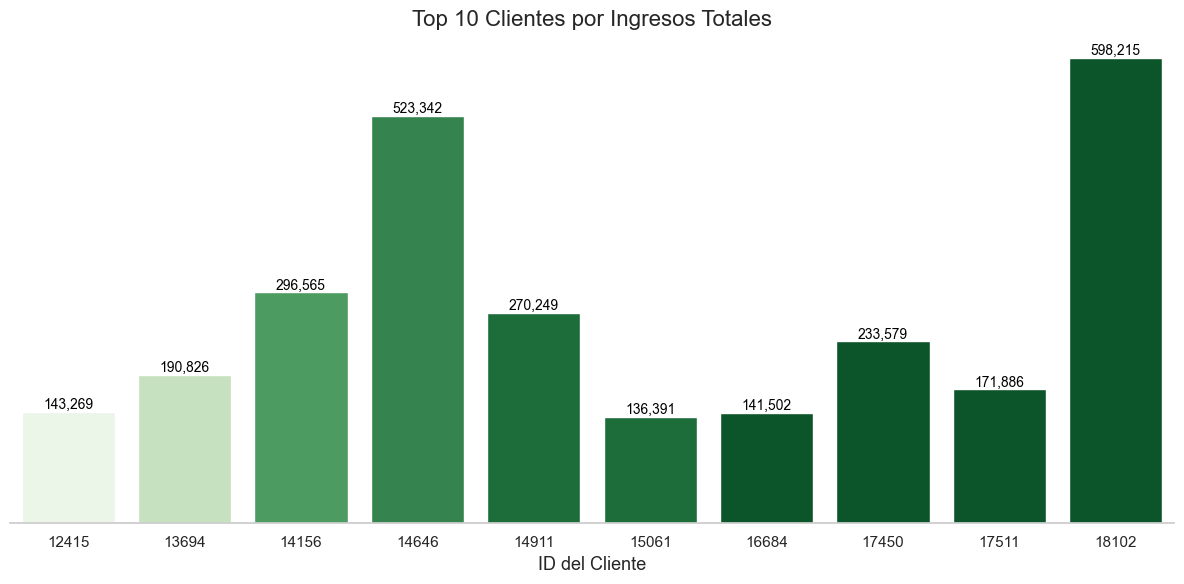

In [57]:
# Agrupar por cliente y obtener los 10 con mayor ingreso
top_clients = df.groupby('Customer ID')['TotalPrice'].sum().sort_values(ascending=False).head(10).reset_index()

# Normalizar ingresos
from matplotlib.colors import Normalize
norm = Normalize(vmin=top_clients['TotalPrice'].min(), vmax=top_clients['TotalPrice'].max())

# Obtener paleta en orden inverso (más ingresos = más oscuro)
colors = sns.color_palette("Greens", len(top_clients))[::-1]
mapped_colors = [colors[int(norm(val)*(len(colors)-1))] for val in top_clients['TotalPrice']]

# Crear gráfico
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x="Customer ID",
    y="TotalPrice",
    data=top_clients,
    palette=mapped_colors
)

# Títulos y etiquetas
plt.title("Top 10 Clientes por Ingresos Totales", fontsize=16)
plt.xlabel("ID del Cliente")
plt.ylabel("")
ax.yaxis.set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Agregar etiquetas encima de las barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

plt.tight_layout()
plt.show()

#### Análisis / Insight: Distribución de compras – Top 10 clientes por ingresos totales


Este gráfico permite visualizar a los 10 clientes que más ingresos generaron durante el período analizado. El cliente con ID `18102`, por ejemplo, supera los **590K**, lo que lo posiciona claramente como un cliente VIP.

Se observa una fuerte **concentración de ingresos en pocos clientes**, lo que refuerza el principio de Pareto: un porcentaje pequeño de clientes representa una parte significativa de la facturación.

---

**Implicancias comerciales:**

- ✅ Diseñar campañas de fidelización para los clientes más rentables.  
- ✅ Monitorear continuamente el comportamiento de estos clientes estratégicos.  
- ✅ Evaluar el riesgo asociado a una posible dependencia de un grupo reducido de compradores.  
- ✅ Aplicar análisis complementarios como RFM para segmentar mejor a la base de clientes.

### Gráfico 2: Distribucion de clientes según frecuencia de compras

Este gráfico muestra cuántos clientes realizaron **una sola compra** en todo el período. Estos clientes pueden considerarse inactivos o de baja fidelidad, y representan una oportunidad importante para acciones de retención, análisis de experiencia de compra o campañas de remarketing.

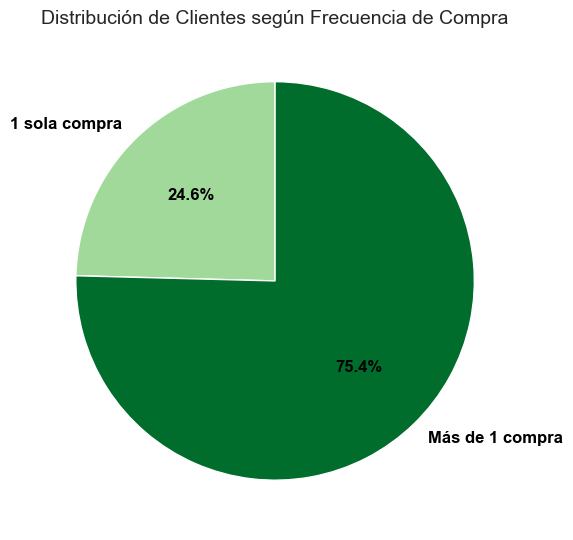

In [58]:
# Calcular base de datos
compras_por_cliente = df.groupby('Customer ID')['Invoice'].nunique().reset_index()
clientes_una_vez = compras_por_cliente[compras_por_cliente['Invoice'] == 1]
clientes_mas_de_una = compras_por_cliente[compras_por_cliente['Invoice'] > 1]

# Datos
valores = [len(clientes_una_vez), len(clientes_mas_de_una)]
etiquetas = ['1 sola compra', 'Más de 1 compra']
colores = ['#a1d99b', '#006d2c']  # verde claro y oscuro

# Gráfico de torta 
plt.figure(figsize=(6,6))
plt.pie(
    valores,
    labels=etiquetas,
    autopct=lambda p: f'{p:.1f}%',  # formato simple
    startangle=90,
    colors=colores,
    textprops={'fontsize': 12, 'fontweight': 'bold', 'color': 'black'}  # mejoras aquí
)
plt.title('Distribución de Clientes según Frecuencia de Compra', fontsize=14)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Distribución de compras por cliente (1 sola compra vs. más de una)

El gráfico de torta muestra que el **24.6% de los clientes realizaron solo una compra**, mientras que el **75.4% compró en más de una ocasión**.

Aunque el porcentaje de clientes inactivos no es alarmante, representa una parte significativa de la base total. Esto indica que una **de cada cuatro personas no regresó a comprar**, lo cual puede estar asociado a factores como:

- Falta de estrategias de fidelización
- Experiencias de compra no satisfactorias
- Ausencia de incentivos para la recompra

---

**Implicancias comerciales:**

- ✅ Es clave implementar campañas de **retargeting** y **email marketing** para reactivar a estos clientes.  
- ✅ Se recomienda investigar si los clientes que no repiten comparten patrones similares (producto, país, canal).  
- ✅ También puede ser útil revisar las primeras experiencias de compra o políticas postventa.

Este análisis ayuda a identificar **oportunidades concretas de retención y mejora de la recurrencia**.


## 4. ¿Cuál es la distribución geográfica de las ventas?

### Gráfico 1: Top 10 Países por Ingresos Totales (Clientes VIP incluidos)

Este gráfico muestra qué países generan mayores ingresos totales (`TotalPrice`) en el periodo analizado. Permite detectar los mercados más relevantes y visualizar su peso en la facturación global.

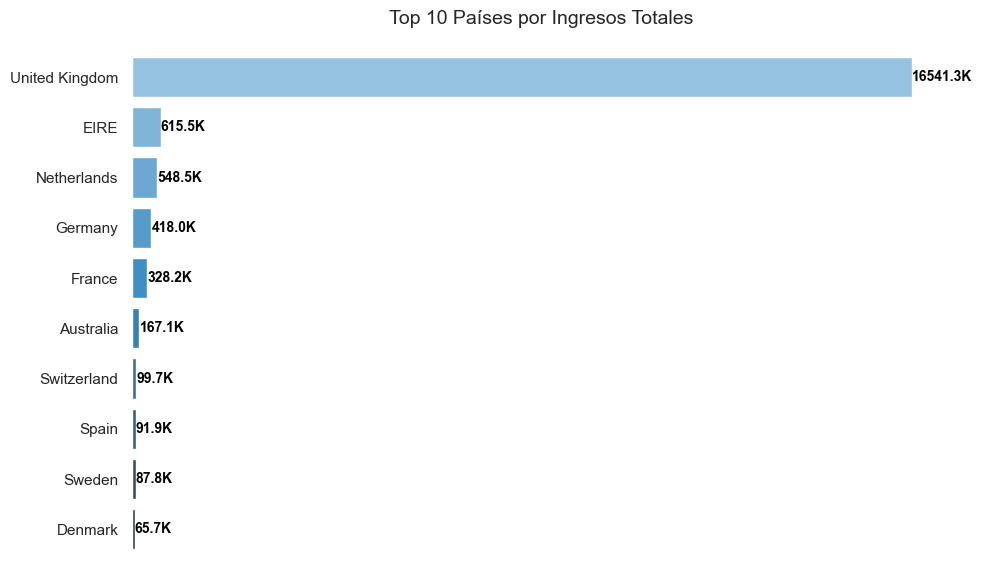

In [66]:
# Agrupar por país y sumar los ingresos totales
ingresos_por_pais = df.groupby("Country")["TotalPrice"].sum().sort_values(ascending=False).head(10)

# Crear gráfico 
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues_d", len(ingresos_por_pais))  # Azul más profundo

bars = plt.barh(
    ingresos_por_pais.index[::-1],  # Mostrar el país con más ingresos arriba
    ingresos_por_pais.values[::-1],
    color=colors[::-1]
)

# Agregar etiquetas de valor (en miles)
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 1000,
        bar.get_y() + bar.get_height() / 2,
        f"{width / 1000:.1f}K",
        va='center',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Estética final
plt.title('Top 10 Países por Ingresos Totales', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.gca().spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.tight_layout()
plt.show()

### Gráfico 2: Gasto Medio por País

Este gráfico muestra el promedio de gasto por cliente en los 10 países con mayor valor promedio.  
La métrica utilizada es el total facturado (`TotalPrice`) dividido entre la cantidad de clientes únicos por país.  
Este análisis permite identificar regiones donde, aunque haya menos clientes, su nivel de gasto es significativamente alto.

c:\Users\LORENA SIERRA\OneDrive\Desktop\GITHUB\Analisis de Datos\env\Lib\site-packages\matplotlib\transforms.py:2436: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
c:\Users\LORENA SIERRA\OneDrive\Desktop\GITHUB\Analisis de Datos\env\Lib\site-packages\matplotlib\transforms.py:351: RuntimeWarning: invalid value encountered in scalar subtract
  return points[1, 0] - points[0, 0]


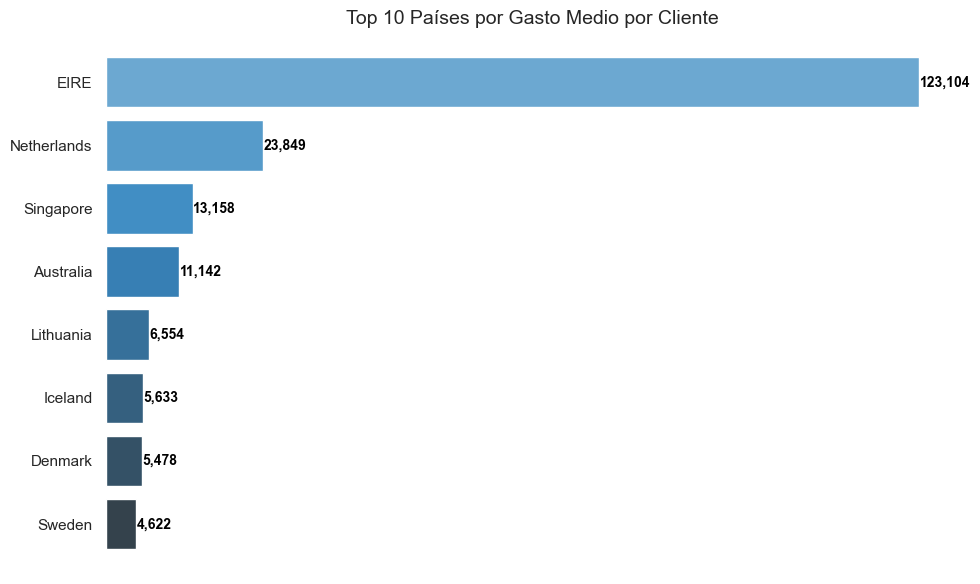

In [65]:
# Calcular gasto total y clientes únicos por país
gasto_total = df.groupby('Country')['TotalPrice'].sum()
clientes_unicos = df.groupby('Country')['Customer ID'].nunique()

# Calcular gasto medio por cliente
gasto_medio = (gasto_total / clientes_unicos).dropna().sort_values(ascending=False).head(10)

# Crear gráfico de barras horizontales
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues_d", len(gasto_medio))  # Paleta azul más oscura

bars = plt.barh(gasto_medio.index[::-1], gasto_medio.values[::-1], color=colors[::-1])

# Agregar valores al lado derecho de cada barra
for bar in bars:
    width = bar.get_width()
    plt.text(width + 100, bar.get_y() + bar.get_height()/2,
             f"{width:,.0f}", va='center', fontsize=10, fontweight='bold', color='black')

# Estética del gráfico
plt.title('Top 10 Países por Gasto Medio por Cliente', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.gca().spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Gasto Medio por Cliente

Este gráfico revela cuáles son los países donde, en promedio, cada cliente gasta más dinero.

---

**🔍 Observaciones clave:**

- 🇮🇪 **EIRE (Irlanda)** lidera con una diferencia sorprendente: sus clientes gastan en promedio más de **123,000 GBP**, muy por encima del resto.
- 🇳🇱 **Netherlands**, 🇸🇬 **Singapore** y 🇦🇺 **Australia** siguen en el ranking, pero con un promedio mucho más bajo.
- 🌍 En este caso, no aparece el Reino Unido, lo cual indica que tiene muchos clientes pero con un gasto promedio más bajo por persona.

---

**📌 Implicancias comerciales:**

- ✅ Países con alto gasto medio son candidatos ideales para lanzar productos **premium**, ofrecer paquetes exclusivos o extender programas de fidelización.
- ✅ El caso de EIRE merece una investigación particular: ¿son empresas mayoristas?, ¿revendedores?, ¿consumidores finales con alta frecuencia de compra?
- ✅ Este análisis complementa muy bien al gráfico anterior, ya que **no mide volumen total, sino calidad del cliente** desde el punto de vista del ingreso individual.

Este tipo de visión es útil para priorizar mercados no solo por cantidad de ventas, sino por **valor estratégico de cada cliente**.


### Gráfico 3: Porcentaje de Devoluciones por País

Este gráfico muestra qué porcentaje de las compras en cada país corresponden a devoluciones, identificadas por facturas tipo “C”. Esto permite detectar regiones donde el nivel de insatisfacción o error logístico puede ser más alto y, por lo tanto, representan áreas críticas para mejoras operativas o atención postventa.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\2432821951.py:41: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\LORENA SIERRA\OneDrive\Desktop\GITHUB\Analisis de Datos\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


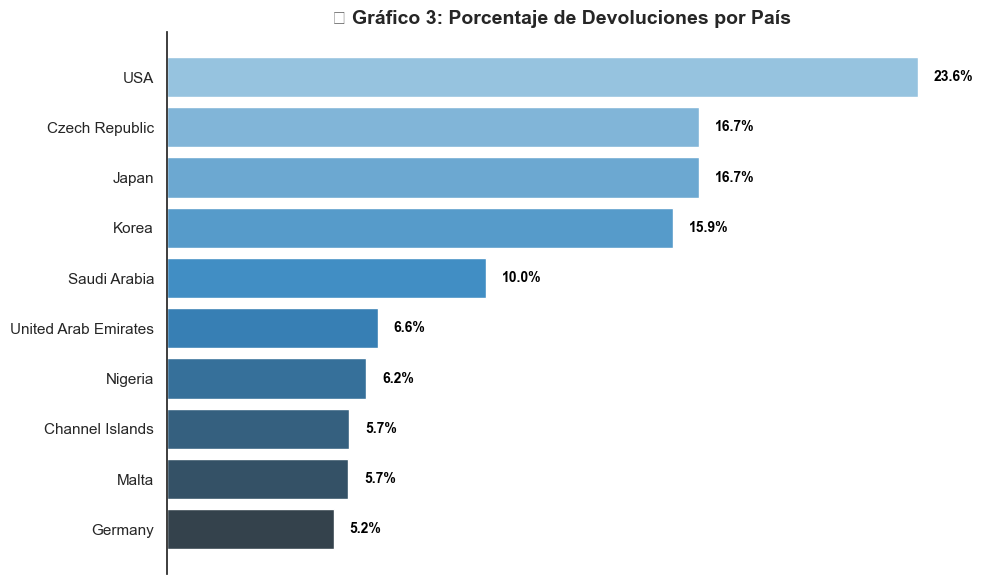

In [67]:
# Filtrar devoluciones por tipo de factura "C"
df['IsReturn'] = df['Invoice'].astype(str).str.startswith('C')

# Calcular total de facturas y devoluciones por país
total_por_pais = df.groupby('Country')['Invoice'].count()
devoluciones_por_pais = df[df['IsReturn']].groupby('Country')['Invoice'].count()

# Calcular porcentaje de devoluciones
porcentaje_devoluciones = (devoluciones_por_pais / total_por_pais * 100).dropna()
porcentaje_devoluciones = porcentaje_devoluciones.sort_values(ascending=False).head(10)

# Gráfico
plt.figure(figsize=(10, 6))
colors = sns.color_palette("Blues_d", len(porcentaje_devoluciones))

bars = plt.barh(
    porcentaje_devoluciones.index[::-1],
    porcentaje_devoluciones.values[::-1],
    color=colors[::-1]
)

# Etiquetas en las barras
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.5,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}%",
        va='center',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Estética
plt.title('📊 Gráfico 3: Porcentaje de Devoluciones por País', fontsize=14, weight='bold')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.gca().spines[['top', 'right', 'bottom']].set_visible(False)
plt.tight_layout()
plt.show()

#### 📊 Análisis / Insight: Porcentaje de Devoluciones por País

Este gráfico permite identificar en qué países es más probable que los clientes devuelvan productos, utilizando como indicador las facturas que comienzan con la letra **“C”**. Detectar estas tendencias puede ayudar a mejorar procesos logísticos, atención al cliente y gestión de calidad.

---

**🔍 Observaciones clave:**

- Países como **USA**, **Japan** y **Czech Republic** presentan tasas de devolución por encima del **15%**, lo que podría reflejar errores sistemáticos o niveles bajos de satisfacción.
- **USA** destaca con una devolución del **23.6%**, cifra significativamente superior al resto.
- Aunque algunos países tienen porcentajes altos, es necesario analizar también el volumen de ventas para poner en contexto el impacto real.
- Este patrón puede estar influido por políticas de devolución locales, problemas logísticos o incluso barreras culturales en la experiencia postventa.

---

**📌 Recomendaciones:**

- ✅ Revisar los productos más devueltos por país y detectar patrones comunes.
- ✅ Evaluar procesos de empaque, calidad o entrega en regiones con mayores tasas de devolución.
- ✅ Aplicar encuestas de satisfacción o programas piloto de mejora postventa en países críticos.
- ✅ Ajustar descripciones o políticas de devolución si se detecta confusión en ciertos mercados.

Este análisis aporta una mirada clave para optimizar la logística y fidelizar clientes en regiones estratégicas.

## 5. ¿Qué decisiones comerciales se pueden tomar a partir de esto?
### Gráfico 1: Correlación entre Quantity, Price y TotalPrice

Este gráfico muestra la correlación entre las variables numéricas clave del análisis:  
- `Quantity`: cantidad de productos por línea  
- `Price`: precio unitario  
- `TotalPrice`: monto total de cada línea de factura

La matriz de correlación permite identificar relaciones directas o inversas entre las variables, lo cual es útil para tomar decisiones sobre precios, promociones o control de stock.

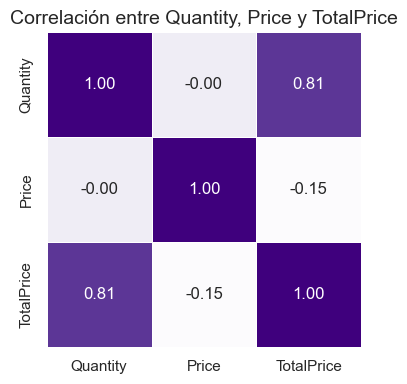

In [69]:
# Seleccionar variables numéricas clave
variables = df[['Quantity', 'Price', 'TotalPrice']]

# Calcular matriz de correlación
corr = variables.corr()

# Crear heatmap con tono morado/lila
plt.figure(figsize=(6, 4))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap='Purples',  # 🔁 Morado oscuro
    square=True,
    linewidths=0.5,
    cbar=False
)
plt.title("Correlación entre Quantity, Price y TotalPrice", fontsize=14)
plt.tight_layout()
plt.show()


#### Análisis / Insight: Correlación de Variables Clave

Este gráfico muestra la relación entre las tres variables más importantes del análisis de ventas: `Quantity`, `Price` y `TotalPrice`. La matriz de correlación permite entender cómo interactúan entre sí, lo cual es útil para definir estrategias de precios, promociones o control de inventario.

---

**🔍 Observaciones clave:**

-  **`Quantity` y `TotalPrice`** presentan una **fuerte correlación positiva (0.81)**. Esto confirma que, como es de esperarse, un mayor número de unidades vendidas genera mayor ingreso.
-  **`Price` y `TotalPrice`** tienen una **correlación negativa débil (-0.15)**, lo que sugiere que los productos más caros no necesariamente generan más ingresos totales, posiblemente porque se venden en menor cantidad.
- ➖ **`Quantity` y `Price`** muestran **casi nula correlación**, lo que indica que los clientes compran tanto productos baratos como caros en cantidades variables, sin un patrón claro entre ambas variables.

---

Recomendaciones estratégicas:

- ✅ Evaluar si los productos con alto precio pero baja cantidad vendida podrían beneficiarse de promociones u ofertas para aumentar su volumen.
- ✅ Priorizar productos que combinan buen volumen de ventas con precio razonable, ya que son los que más impulsan el ingreso (`TotalPrice`).
- ✅ Esta matriz valida el uso de `TotalPrice` como variable objetivo en futuros modelos de predicción o segmentación de clientes.

---

Este análisis es un paso esencial para **tomar decisiones basadas en datos reales**, minimizando suposiciones y optimizando la estrategia comercial.

### Gráfico 2: Detección de Outliers en Variables Clave

Este gráfico utiliza diagramas de caja (*boxplots*) para visualizar los valores extremos en las variables `Quantity`, `Price` y `TotalPrice`.  
Los outliers pueden representar errores, devoluciones, compras masivas o situaciones particulares del negocio que requieren revisión.  
Detectarlos ayuda a mejorar la limpieza de datos, prevenir decisiones sesgadas y ajustar reglas de negocio.

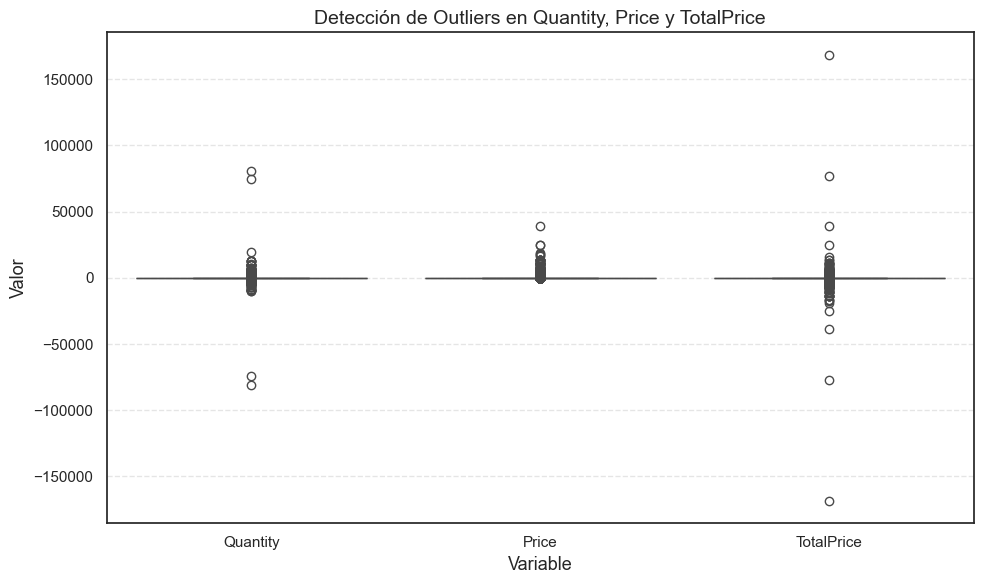

In [73]:
# Variables que vamos a analizar
variables_outliers = ['Quantity', 'Price', 'TotalPrice']

# Crear gráfico de caja
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=df[variables_outliers],
    palette='Purples'  # Estilo morado para Pregunta 5
)

# Estética del gráfico
plt.title('Detección de Outliers en Quantity, Price y TotalPrice', fontsize=14)
plt.xlabel('Variable')
plt.ylabel('Valor')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Detección de Outliers

Este gráfico muestra los valores atípicos (outliers) presentes en las variables más relevantes: `Quantity`, `Price` y `TotalPrice`.  
Se utilizaron diagramas de caja (*boxplots*) que permiten visualizar tanto la concentración de los datos como los casos extremos que se alejan significativamente del rango normal.

---

**🔍 Observaciones clave:**

- **`Quantity`** presenta varios outliers, tanto positivos como negativos. Algunos valores negativos podrían corresponder a devoluciones, pero otros podrían requerir validación o limpieza.
- **`Price`** también tiene valores extremos altos, posiblemente relacionados con errores de carga o productos con precios poco habituales (como combos, muebles o antigüedades).
- **`TotalPrice`** refleja la combinación de ambas variables, mostrando grandes montos de venta (o devolución) que podrían tener un impacto fuerte en el análisis si no se tratan adecuadamente.

---

Recomendaciones de acción:

- ✅ Verificar registros con valores negativos y extremos: pueden distorsionar estadísticas como media y desviación estándar.
- ✅ Evaluar si es necesario imputar, eliminar o aislar los outliers según su naturaleza (error, excepción o comportamiento real).
- ✅ Considerar crear reglas de negocio para detectar automáticamente este tipo de casos en futuras cargas de datos.

---

La detección temprana de outliers permite mejorar la calidad del análisis y tomar decisiones más robustas basadas en datos confiables.


## 6. ¿Qué productos presentan mayor tasa de devolución?
### Gráfico 1: Top 5 Productos con Más Devoluciones

Este gráfico muestra los productos que han sido más devueltos, identificados por tener valores negativos en la columna Quantity. Analizar estos productos puede ayudar a detectar fallas en la calidad, errores en el picking, problemas con la descripción del catálogo o insatisfacción del cliente.

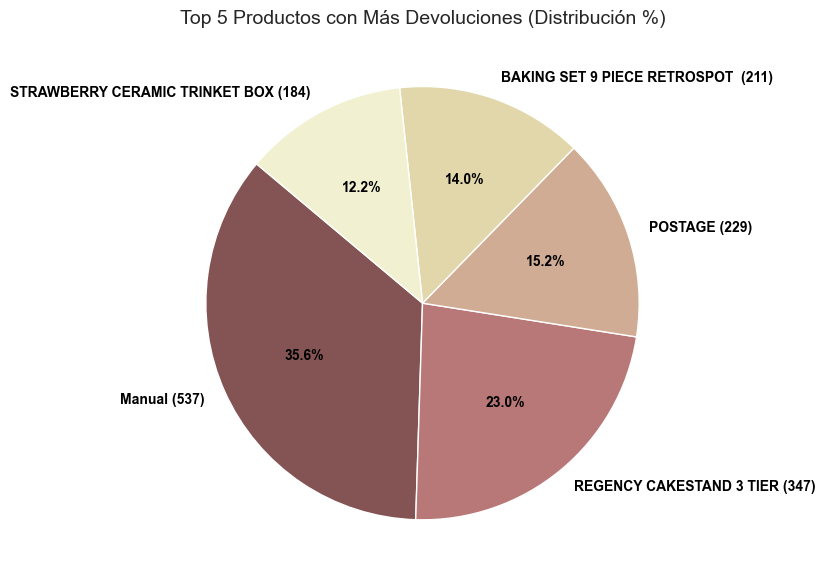

In [78]:
# Filtrar registros con devoluciones (Quantity negativa)
devoluciones = df[df['Quantity'] < 0]

# Agrupar por producto y contar cuántas veces fue devuelto
prod_devueltos = devoluciones['Description'].value_counts().head(5)

# Preparar datos
labels = prod_devueltos.index
sizes = prod_devueltos.values

# Colores rosa suave
colors = sns.color_palette("pink", len(prod_devueltos))

# Crear gráfico de torta
plt.figure(figsize=(8, 6))
plt.pie(
    sizes,
    labels=[f"{prod} ({cant})" for prod, cant in zip(labels, sizes)],
    colors=colors,
    autopct='%1.1f%%',
    startangle=140,
    textprops={'fontsize': 10, 'weight': 'bold', 'color': 'black'}
)

# Título del gráfico
plt.title("Top 5 Productos con Más Devoluciones (Distribución %)", fontsize=14)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Top 5 Productos con Más Devoluciones

Este gráfico muestra los productos que han sido devueltos con mayor frecuencia, identificados a partir de registros con `Quantity` negativa. La visualización permite detectar posibles problemas relacionados con la calidad del producto, descripciones confusas o expectativas no cumplidas.

---

Observaciones clave:

- **"Manual"** lidera el ranking de devoluciones, con **537 registros**, lo que podría indicar errores de carga, ya que su nombre es genérico y puede no corresponder a un producto real.
- **"REGENCY CAKESTAND 3 TIER"** y **"BAKING SET 9 PIECE RETROSPOT"** también figuran en el top, ambos asociados a artículos de cocina o decoración frágil.
- **"POSTAGE"** aparece como producto devuelto, lo que sugiere posibles devoluciones de cargos de envío, ajustes administrativos o errores de facturación.
- **"STRAWBERRY CERAMIC TRINKET BOX"** es un ejemplo claro de producto decorativo que puede sufrir roturas o decepcionar por tamaño o diseño.

---

Recomendaciones de acción:

- ✅ Verificar si algunos nombres como "Manual" o "Postage" son errores de sistema o ítems que deben ser tratados aparte.
- ✅ Revisar embalajes y descripciones de productos frágiles o altamente devueltos.
- ✅ Aplicar reglas de control para identificar causas frecuentes de devolución y anticiparse a problemas logísticos o de catálogo.

---

Este tipo de análisis ayuda a detectar puntos críticos en la experiencia del cliente y contribuye a reducir pérdidas por devoluciones evitables.

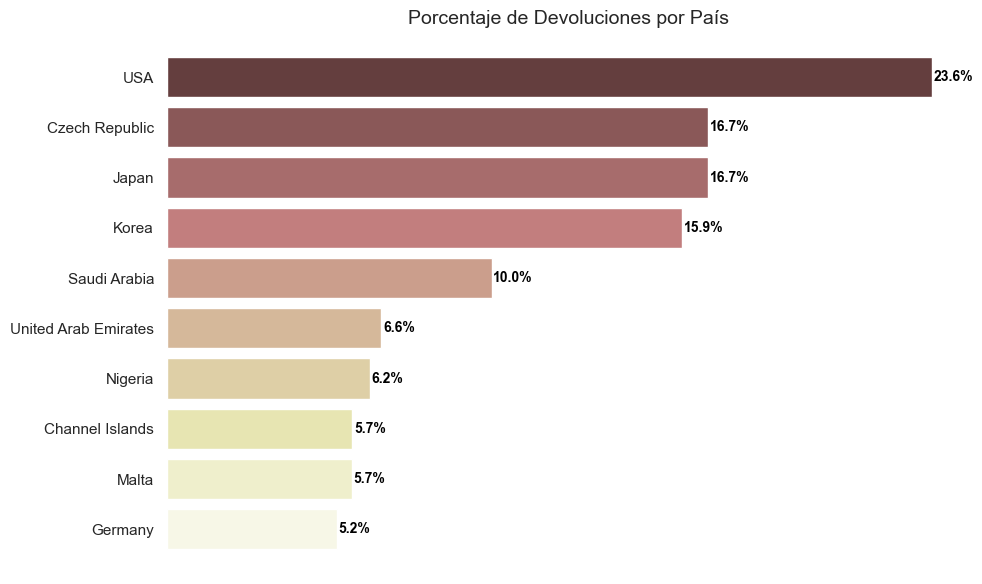

In [76]:
# Agrupar y calcular porcentaje de devoluciones por país
# (Este bloque asume que ya tenés una columna 'Country' y 'Quantity' en el df)

# Total de registros por país
total_por_pais = df.groupby('Country').size()

# Total de devoluciones por país (Quantity negativa)
devoluciones_por_pais = df[df['Quantity'] < 0].groupby('Country').size()

# Calcular porcentaje
porcentaje_dev = (devoluciones_por_pais / total_por_pais * 100).dropna().sort_values(ascending=False).head(10)

# Crear gráfico
plt.figure(figsize=(10, 6))
colors = sns.color_palette("pink", len(porcentaje_dev))

bars = plt.barh(
    porcentaje_dev.index[::-1],
    porcentaje_dev.values[::-1],
    color=colors[::-1]
)

# Etiquetas
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 0.05,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.1f}%",
        va='center',
        fontsize=10,
        fontweight='bold',
        color='black'
    )

# Estética
plt.title('Porcentaje de Devoluciones por País', fontsize=14)
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.gca().spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.tight_layout()
plt.show()

#### Análisis / Insight: Porcentaje de Devoluciones por País

Este gráfico muestra el porcentaje de devoluciones en relación al total de transacciones por país.  
El objetivo es identificar qué regiones presentan una mayor frecuencia relativa de devoluciones, lo cual puede revelar problemas específicos de logística, expectativas del cliente, barreras culturales o fallas en productos.

---

Observaciones clave:

- **USA** lidera con un preocupante **23.6% de devoluciones**, lo cual sugiere que casi 1 de cada 4 transacciones termina en una devolución. Esto podría deberse a problemas de envío internacional, aranceles, o productos no adaptados al mercado.
- **Czech Republic**, 🇯🇵 **Japan** y 🇰🇷 **Korea** también presentan tasas altas, por encima del 15%, lo cual podría indicar desajustes culturales o expectativas no satisfechas.
- Países como 🇩🇪 **Germany**, 🇲🇹 **Malta** y 🇳🇬 **Nigeria** tienen tasas más moderadas (entre 5 y 6%), aunque aún pueden ser relevantes dependiendo del volumen total de ventas.

---
Recomendaciones estratégicas:

- ✅ Analizar causas específicas de devolución en países con tasas altas: productos más afectados, tipos de errores o motivos frecuentes.
- ✅ Evaluar si las descripciones del catálogo están correctamente localizadas o traducidas.
- ✅ Reforzar políticas de envío, empaque y atención al cliente en mercados críticos como EE.UU., Asia y Medio Oriente.

---

Este tipo de análisis permite tomar decisiones geográficas y adaptar la operación comercial a las particularidades de cada país para **reducir devoluciones y mejorar la experiencia del cliente**.

## 7. ¿Qué tipo de cliente es más rentable y cómo se puede fidelizar?

### Gráfico 1: Análisis RFM – Relación entre Frecuencia, Monto y Recencia

Este gráfico de dispersión forma parte del análisis RFM (**Recency, Frequency, Monetary**) y permite observar el comportamiento de los clientes según tres dimensiones clave:

- **Recency**: Cuántos días pasaron desde la última compra.
- **Frequency**: Cuántas compras realizó el cliente.
- **Monetary**: Cuánto gastó en total.

El eje X representa la **frecuencia**, el eje Y el **valor monetario total**, y el color/tamaño del punto indica la **recencia**.

Esta visualización permite **detectar perfiles valiosos** (frecuentes, gastadores y recientes) y diseñar estrategias personalizadas de fidelización o recuperación.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\1404843644.py:39: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\LORENA SIERRA\OneDrive\Desktop\GITHUB\Analisis de Datos\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


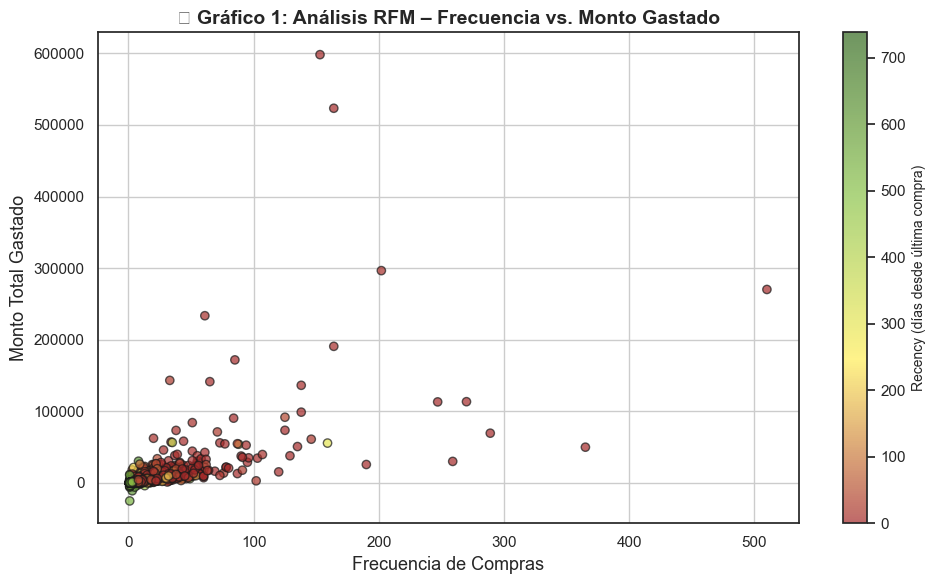

In [89]:
from matplotlib.colors import LinearSegmentedColormap

# Asegurar tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
fecha_ref = df['InvoiceDate'].max()

# Calcular RFM
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (fecha_ref - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Crear colormap otoñal personalizado
colores_otono = ['#A52A2A', '#FFEE58', '#8BC34A', '#33691E']  # maroon, amarillo, verde manzana, verde oscuro
cmap_otono = LinearSegmentedColormap.from_list("Otono", colores_otono, N=256)

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
scatter = plt.scatter(
    rfm['Frequency'], 
    rfm['Monetary'], 
    c=rfm['Recency'], 
    cmap=cmap_otono,
    alpha=0.7,
    edgecolors='k'
)

# Barra de color
cbar = plt.colorbar(scatter)
cbar.set_label('Recency (días desde última compra)', fontsize=10)

# Títulos y estilo
plt.title('📊 Gráfico 1: Análisis RFM – Frecuencia vs. Monto Gastado', fontsize=14, weight='bold')
plt.xlabel('Frecuencia de Compras')
plt.ylabel('Monto Total Gastado')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Análisis / Insight: RFM – Frecuencia vs. Monto Gastado

Este gráfico permite visualizar el comportamiento de los clientes según la **frecuencia de sus compras** y el **monto total gastado**, con un tercer eje representado por el color: la **recencia** (número de días desde la última compra).

El análisis RFM (Recency, Frequency, Monetary) es clave para segmentar clientes según su valor y diseñar estrategias de fidelización o reactivación más eficaces.

---

Observaciones clave:

- La mayoría de los clientes se concentra en valores bajos de frecuencia y gasto, lo cual es esperable.
- Algunos puntos aislados con **alto gasto y alta frecuencia** representan a los **clientes más rentables**, aunque muchos de ellos no han comprado recientemente (color más claro).
- Se observan también casos con alto gasto pero **baja frecuencia**, lo que puede indicar compras únicas muy grandes (clientes de alto valor potencial).
- El color más oscuro representa clientes que **compraron recientemente**, y su análisis ayuda a detectar grupos activos vs. inactivos.

---

Recomendaciones:

- ✅ **Segmentar a los clientes** con alta frecuencia y alto gasto como “Clientes VIP” para priorizar su fidelización.
- ✅ **Reactivar clientes** con alto valor monetario pero que no han comprado recientemente (color claro).
- ✅ Evaluar si los clientes de baja frecuencia y bajo gasto podrían ser incentivados con promociones específicas.
- ✅ Utilizar esta segmentación para campañas de marketing personalizadas (por ejemplo: email marketing, descuentos exclusivos, recordatorios).

Este análisis permite tomar decisiones más inteligentes orientadas a **retener a los clientes más valiosos** y **reconquistar a los inactivos con potencial de compra**.

### Gráfico 2: Segmentación de clientes (VIP, en riesgo, nuevos, etc.)
Este gráfico muestra la segmentación de clientes según sus puntuaciones RFM, agrupándolos en categorías clave como:

Clientes VIP: Alta frecuencia, gasto elevado y compras recientes.

Clientes en riesgo: Compraban mucho antes, pero ya no lo hacen.

Clientes nuevos: Recientes, pero aún sin frecuencia o gasto alto.

Clientes leales: Compran seguido, aunque no gastan tanto.

Esto permite diseñar estrategias personalizadas de marketing y retención según el perfil de cada grupo.



C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\3546151313.py:58: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\LORENA SIERRA\OneDrive\Desktop\GITHUB\Analisis de Datos\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


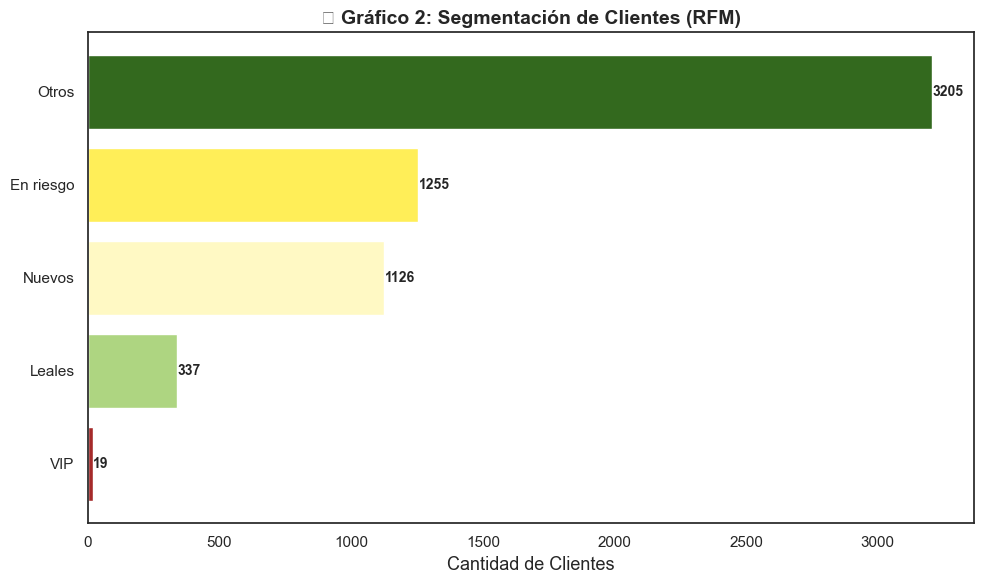

In [87]:
# Convertir fecha
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
fecha_ref = df['InvoiceDate'].max()

# Calcular RFM
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (fecha_ref - x.max()).days,
    'Invoice': 'nunique',
    'TotalPrice': 'sum'
})
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# Cuartiles
rfm['R_Quartile'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Quartile'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Quartile'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])
rfm[['R_Quartile', 'F_Quartile', 'M_Quartile']] = rfm[['R_Quartile', 'F_Quartile', 'M_Quartile']].astype(int)

# Segmentar
def segmentar_cliente(r, f, m):
    if r == 1 and f == 4 and m == 4:
        return 'VIP'
    elif r == 1 and (f >= 3 or m >= 3):
        return 'Leales'
    elif r == 4 and (f >= 3 or m >= 3):
        return 'En riesgo'
    elif r == 1:
        return 'Nuevos'
    else:
        return 'Otros'

rfm['Segmento'] = rfm.apply(lambda row: segmentar_cliente(row['R_Quartile'], row['F_Quartile'], row['M_Quartile']), axis=1)

# Conteo
segmentos = rfm['Segmento'].value_counts().sort_values(ascending=True)

# Colores
colores_segmentos = {
    'Otros': '#33691E',     # Verde bosque oscuro
    'Nuevos': '#FFF9C4',    # Amarillo crema
    'En riesgo': '#FFEE58', # Amarillo pastel
    'Leales': '#AED581',    # Verde lima suave
    'VIP': '#A52A2A'        # Maroon / rojo otoñal
}

# Gráfico
plt.figure(figsize=(10, 6))
bars = plt.barh(segmentos.index, segmentos.values, color=[colores_segmentos[seg] for seg in segmentos.index])

# Etiquetas
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height() / 2, f"{width}", va='center', fontsize=10, fontweight='bold')

# Estética
plt.title('📊 Gráfico 2: Segmentación de Clientes (RFM)', fontsize=14, weight='bold')
plt.xlabel('Cantidad de Clientes')
plt.tight_layout()
plt.show()

####  Análisis / Insight: Segmentación de Clientes (RFM)

Este gráfico presenta la segmentación de los clientes de acuerdo con el modelo **RFM** (Recency, Frequency, Monetary), clasificándolos en cinco categorías clave. Cada grupo fue visualizado con una paleta de tonos verdes y amarillos suaves, y un rojo oscuro para los VIP, destacando su perfil y cantidad dentro del universo de clientes.

---

Observaciones clave:

- La mayoría de los clientes (**3205**) se encuentran en el segmento **“Otros”**, lo que indica que no tienen un comportamiento destacado en recencia, frecuencia ni valor monetario. Representan una base amplia, pero poco rentable.
- El grupo **“En riesgo”** (**1255**) reúne a clientes que alguna vez fueron valiosos pero ya no compran. Representan una gran **oportunidad de reactivación**.
- Los **“Nuevos”** (**1126**) tienen alta recencia pero aún no compran frecuentemente ni gastan mucho. Son clave para estrategias de **fidelización temprana**.
- Los **“Leales”** (**337**) compran con frecuencia y aportan valor constante. Merecen acciones de **recompensa y mantenimiento**.
- Solo **19 clientes son “VIP”**, lo que indica que el grupo más valioso es pequeño pero crítico. Estos clientes deben ser cuidados con ofertas exclusivas y trato preferencial.

---

Recomendaciones:

- ✅ **Diseñar campañas personalizadas** para cada segmento. Por ejemplo:
  - “VIP”: programas de fidelización premium.
  - “En riesgo”: emails de recuperación con descuentos.
  - “Nuevos”: onboarding con recomendaciones y beneficios iniciales.
- ✅ **Reducir el tamaño del grupo “Otros”** con acciones de remarketing o detección de patrones inactivos.
- ✅ **Analizar por qué hay tan pocos VIPs**. ¿Es por barreras de compra, falta de recompensas o bajo volumen de tickets?
- ✅ Establecer una estrategia de **recurrencia y valor creciente** para convertir “Nuevos” en “Leales” y eventualmente en “VIP”.

Este análisis RFM es fundamental para la toma de decisiones orientadas a la **retención, crecimiento de valor por cliente y optimización del marketing personalizado**.

### Gráfico 3: Comparación entre Clientes Nuevos vs Recurrentes
Este gráfico permite ver cuántos clientes fueron nuevos (primera compra en el período) versus recurrentes (ya habían comprado antes). Es útil para entender si el negocio está atrayendo nuevos compradores o fidelizando a los existentes.

C:\Users\LORENA SIERRA\AppData\Local\Temp\ipykernel_10356\156711761.py:27: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\LORENA SIERRA\OneDrive\Desktop\GITHUB\Analisis de Datos\env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


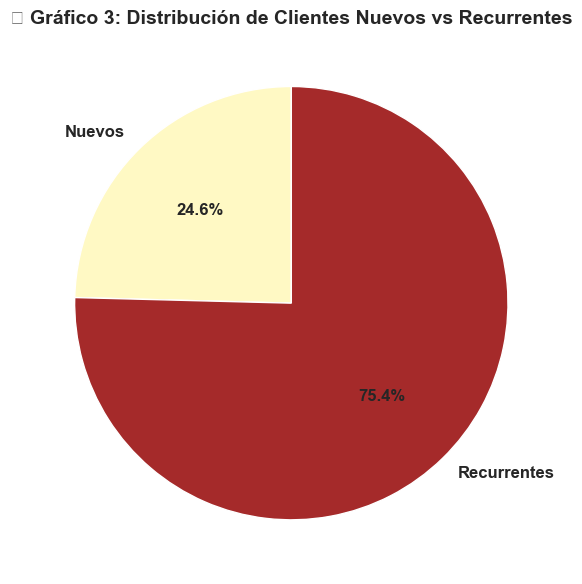

In [92]:
# Asegurar que 'InvoiceDate' sea tipo datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Agrupar por cliente y contar la cantidad de facturas distintas
compras_por_cliente = df.groupby('Customer ID')['Invoice'].nunique()

# Clasificar: nuevos (1 compra) vs recurrentes (>1)
nuevos = compras_por_cliente[compras_por_cliente == 1].count()
recurrentes = compras_por_cliente[compras_por_cliente > 1].count()

# Datos para el gráfico
valores = [nuevos, recurrentes]
labels = ['Nuevos', 'Recurrentes']
colores = ['#FFF9C4', '#A52A2A']  # Amarillo crema y maroon

# Gráfico de torta
plt.figure(figsize=(6, 6))
plt.pie(
    valores,
    labels=labels,
    colors=colores,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 12, 'weight': 'bold'}
)
plt.title('📊 Gráfico 3: Distribución de Clientes Nuevos vs Recurrentes', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

#### Análisis / Insight: Distribución de Clientes Nuevos vs Recurrentes

Este gráfico muestra la proporción de clientes **nuevos** (aquellos que realizaron solo una compra) frente a los **recurrentes** (con más de una compra) durante el período analizado. La visualización en forma de torta resalta la composición de la base de clientes en términos de fidelización.

---

**🔍 Observaciones clave:**

- El **75.4%** de los clientes son **recurrentes**, lo que indica que una gran parte de los compradores vuelve a realizar una segunda compra o más. Este es un **indicador positivo de retención**.
- Un **24.6%** de los clientes son **nuevos**, lo cual también es saludable: demuestra que la empresa sigue **atrayendo clientes** por primera vez.
- Esta distribución balanceada sugiere que hay una buena combinación entre **adquisición** y **fidelización**, aunque todavía hay espacio para convertir más nuevos en recurrentes.

---

Recomendaciones:

- ✅ Implementar campañas específicas para convertir clientes **nuevos en recurrentes** mediante incentivos para una segunda compra.
- ✅ Identificar qué prácticas o productos están generando mayor **lealtad** entre los recurrentes y replicarlos para nuevos clientes.
- ✅ Medir el tiempo promedio entre la primera y segunda compra para optimizar el **momento de contacto postventa**.
- ✅ Reforzar programas de fidelización para premiar la repetición y aumentar el ticket promedio.
